### Learning trajectory analysis 

##### Look at time trends and analyze various metrics of perforamance and strategy based evaluation methods 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from IPython.display import display, HTML

In [3]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv'
df = pd.read_csv(folder)

/tmp/ipykernel_21303/670866133.py:3: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder)


In [73]:
# Check dimensions and content of dataframe for variables of interest: 

ids = df['subject_id'].unique()
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']
forag_eff_count = df['foraging_eff']
task_count = df['task'].unique()
session_count = df['session'].unique()

print(f'Maximum number of sessions for any given subject: {len(session_count)}')
print(f'\nTypes of tasks: {task_count}, \n Number of unique tasks: {len(task_count)}')
print(f'\n Number of subjects: {len(ids)}')
print(f'\n Types of stages: {num_stage}')
print(f'\n Number of forag efficiency scores: {len(forag_eff_count)}')

Maximum number of sessions for any given subject: 52

Types of tasks: ['Uncoupled Baiting' 'Coupled Baiting' 'Uncoupled Without Baiting'
 'Coupled Without Baiting'], 
 Number of unique tasks: 4

 Number of subjects: 131

 Types of stages: ['STAGE_FINAL' 'STAGE_2' 'GRADUATED' nan 'STAGE_1' 'STAGE_4' 'STAGE_3']

 Number of forag efficiency scores: 2466


In [75]:
# New features: 
# curriculum_version, water_**, effective_block_**, duration_delay_period_**, 
# duration_iti_**, lickspout_movement_**, reward_vol_**, curriculum_schema_version, 
# autowater, finished_rate, bias_naive, reaction_time, early_lick_rate, double_dipping_rate_**,
# lick_consistency_mean_**, weekday, 

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

#### Preprocessing

In [5]:
def filter_by_group_size(df, group_col='subject_id', max_rows=None, category_col=None, category_limits=None, category_max=None):
    """ 
    Filter DataFrame by number of rows globally or by specified categorical column: 

    Params:
    df (DataFrame): Input DataFrame
    group_col (str): feature to group by 
    max_rows (int) (optional): Global maximum number of rows allowed per group 
    category_col (str) (optional): column to filter by 
    category_limits (dict) (optional): mapping category values to their maximum allowed rows 
    category_max (int) (optional): maximum number of allowed rows for any given category in column 

    Returns: 
    df DataFrame: Filtered DataFrame only containing groups with rows <= max_rows

    """ 
    if category_col is not None:
        # Get counts per subject/category 
        group_sizes = df.groupby([group_col, category_col]).size().unstack(fill_value=0)
        
        invalid_groups = set()
        
        # Check category-specific limits
        if category_limits is not None:
            for category, limit in category_limits.items():
                if category in group_sizes.columns:
                    # Find groups that exceed limit
                    over_limit = group_sizes[group_sizes[category] > limit].index
                    invalid_groups.update(over_limit)
        
        # Check global category max limit 
        if category_max is not None:
            # For categories not in category_limits, apply max limit
            for category in group_sizes.columns:
                if category_limits is None or category not in category_limits:
                    over_limit = group_sizes[group_sizes[category] > category_max].index
                    invalid_groups.update(over_limit)
        
        # If neither category_limits nor category_max provided, return original df
        if category_limits is None and category_max is None:
            return df
            
        # Keep only valid groups 
        valid_groups = set(group_sizes.index) - invalid_groups
        
    else:
        # If no categories set, apply global limit or return original DataFrame
        if max_rows is None:
            return df
        
        group_sizes = df[group_col].value_counts()
        valid_groups = group_sizes[group_sizes <= max_rows].index
    
    # Filter the dataframe to keep only valid groups
    filtered_df = df[df[group_col].isin(valid_groups)]
    
    return filtered_df

In [42]:
 # Drop warmup stage 
df = df[df['current_stage_actual'] !='STAGE_1_WARMUP']

# Drop outlier subjects
df = filter_by_group_size(df, category_col='current_stage_actual', category_max=20)


In [43]:
# Check size comparison (original = 730080)
print(df.size)

394560


In [44]:
# Create stage and stage/task DataFrames

main_df = df[['subject_id', 'current_stage_actual','session', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]

main_task_df = df[['subject_id', 'current_stage_actual','session','task', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]

In [45]:
# Fix stage order problem

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

task_vector = ['Uncoupled Without Baiting', 'Coupled Baiting', 'Coupled Without Baiting', 'Uncoupled Baiting']

# Make explicit copy 
main_df = main_df.copy()
main_task_df = main_task_df.copy()


main_df['current_stage_actual'] = pd.Categorical(main_df['current_stage_actual'], categories=stage_vector)

main_task_df['current_stage_actual'] = pd.Categorical(main_task_df['current_stage_actual'], categories=stage_vector)
main_task_df['task'] = pd.Categorical(main_task_df['task'], categories=task_vector)

In [46]:
main_df.head()

,subject_id,current_stage_actual,session,subject_genotype,foraging_eff,foraging_performance,foraging_eff_random_seed
0,751153,STAGE_FINAL,10.0,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.682391,0.682391,0.662963
1,751152,STAGE_FINAL,10.0,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.713930,0.674413,0.745098
2,751147,STAGE_FINAL,10.0,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.776075,0.772828,0.793103
3,747893,STAGE_FINAL,10.0,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.809358,0.807786,0.793566
4,751151,STAGE_FINAL,10.0,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.707485,0.699102,0.722008


In [47]:
main_task_df.head()

,subject_id,current_stage_actual,session,task,subject_genotype,foraging_eff,foraging_performance,foraging_eff_random_seed
0,751153,STAGE_FINAL,10.0,Uncoupled Baiting,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.682391,0.682391,0.662963
1,751152,STAGE_FINAL,10.0,Uncoupled Baiting,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.713930,0.674413,0.745098
2,751147,STAGE_FINAL,10.0,Uncoupled Baiting,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.776075,0.772828,0.793103
3,747893,STAGE_FINAL,10.0,Uncoupled Baiting,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.809358,0.807786,0.793566
4,751151,STAGE_FINAL,10.0,Uncoupled Baiting,Fos2A-iCreER/wt;Ai75(RCL-nT)/wt,0.707485,0.699102,0.722008


##### Cumulative analysis

In [48]:
sns.set_theme()

def analyze_session_distribution(df, task_col=None, bins=20, bins_task=40, y_max=None, y_max_task=None):
    """ 
    Create DataFrame showing the number of sessions per subject per stage and/or task
    with proper density-based distribution visualization
    
    Params: 

    df: DataFrame
        Foraging DataFrame with metric, stage features, task features
    task_col = optional for task DataFrame

    bins (task) = set number of bins for either DataFrame
    ymax (task) = set manual maximum y axis value, if None default will be used
        
    Returns: 
    tuple : (DataFrame, DataFrame)
        session_counts: Individual counts per subject
        summary_stats: Summary statistics of the distribution
    """

    stage_order = df['current_stage_actual'].unique()

    # Group by subject and stage, and task
    if task_col:
        session_counts = (df.groupby(['subject_id', 'current_stage_actual', task_col], observed=True)
                         .agg({'session': 'count'})
                         .reset_index()
                         .rename(columns={'session': 'num_sessions'}))
    else:
        session_counts = (df.groupby(['subject_id', 'current_stage_actual'], observed=True)
                         .agg({'session': 'count'})
                         .reset_index()
                         .rename(columns={'session': 'num_sessions'}))
    
    # Create density plots
    plt.figure(figsize=(12, 6))
    
    # Create distribution plot and proper normalization
    if task_col:
        g = sns.displot(data=session_counts, 
                    x='num_sessions',
                    col='current_stage_actual',
                    row=task_col,
                    kind='hist',
                    bins=bins_task,
                    height=4,
                    aspect=1.5,
                    stat='count',
                    common_norm=False,
                    kde=True)

        # Adjust x-ticks and y-axis limits for all subplots
        for ax in g.axes.flat:
            if y_max is not None:
                ax.set_ylim(0, y_max)
    else:
        g = sns.displot(data=session_counts, 
                    x='num_sessions',
                    col='current_stage_actual',
                    kind='hist',
                    bins=bins,
                    height=4,
                    aspect=1.5,
                    stat='count',
                    common_norm=False,
                    kde=True)
                    
        # Adjust x-ticks and y-axis limits for all subplots
        for ax in g.axes.flat:
            # Calculate bin edges
            edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
            
            # Set x-ticks to bin edges
            ax.set_xticks(edges)
            ax.tick_params(axis='x', rotation=45)
            
            if y_max is not None:
                ax.set_ylim(0, y_max)
    
    if task_col:
        plt.suptitle('Distribution of Session Counts by Stage and Task', y=1.02)
    else:
        plt.suptitle('Distribution of Session Counts by Stage', y=1.02)
    
    # Add more detailed statistics
    if task_col:
        summary_stats = (session_counts.groupby(['current_stage_actual', task_col], observed=True)
                        .agg({
                            'num_sessions': ['count', 'mean', 'std', 'min', 'max', 
                                           lambda x: x.quantile(0.25),
                                           lambda x: x.quantile(0.75)]
                        })
                        .round(2))
    else:
        summary_stats = (session_counts.groupby('current_stage_actual', observed=True)
                        .agg({
                            'num_sessions': ['count', 'mean', 'std', 'min', 'max',
                                           lambda x: x.quantile(0.25),
                                           lambda x: x.quantile(0.75)]
                        })
                        .round(2))
    
    summary_stats.columns = ['num_subjects', 'mean_sessions', 'std_sessions', 
                           'min_sessions', 'max_sessions', 'q25_sessions', 'q75_sessions']
    summary_stats = summary_stats.reset_index()
    
    return session_counts, summary_stats

In [49]:

# Identify sub groups 

def split_by_session_threshold(df, session_counts, threshold=None, task_col=None):
    """ 
    Split DataFrame based on session count Threshold in STAGE_1

    Params:

    df: DataFrame containing all data
    session counts: DataFrame containing session counts per subject_id/stage/task
    threshold: int (optional) based off of prior session count visualization
    task_col: str (optional) for task DataFrame specification 

    Returns:

    tuple: (DataFrame, DataFrame, int): 
            slow_df: DataFrame with subjects above threshold
            fast_df: DataFrame with subjects below threshold
            threshold_value: threshold (int) used for splitting 
    """ 

    # Get Stage 1 counts
    stage_n_counts = session_counts[
        session_counts['current_stage_actual'] == 'STAGE_FINAL'
    ].copy()

    # For task DataFrame average across tasks for Stage 1
    if task_col:
        stage_n_counts = (stage_n_counts.groupby('subject_id')['num_sessions'].mean().reset_index())

    # Use median if no threshold is provided
    if threshold is None:
        threshold_value = stage_n_counts['num_sessions'].median()
    else:
        threshold_value = threshold

    # Get subject_ids below and above threshold
    slow_subjects = stage_n_counts[stage_n_counts['num_sessions'] >= threshold_value]['subject_id'].unique()

    fast_subjects = stage_n_counts[stage_n_counts['num_sessions'] < threshold_value]['subject_id'].unique()

    # Split DataFrame
    slow_df = df[df['subject_id'].isin(slow_subjects)].copy()
    fast_df = df[df['subject_id'].isin(fast_subjects)].copy()

    # Summary stats
    print(f'Threshold value: {threshold_value:.2f} sessions')
    print(f'Number of slow learners {len(slow_subjects)}')
    print(f'Number of fast learners {len(fast_subjects)}')

    return slow_df, fast_df, threshold_value


In [50]:
def analyze_splits(df, task_col=None, threshold=None, **kwargs):
    """
    Analyze session distributions for both slow and fast session count DataFrames

    params:

    df: DataFrame in original analyze_sessions function
    task_col: str (optional) for task-specific DataFrame
    threshold: int (optional) threshold for split calculation
    **kwargs: additional args

    Returns:
    tuple: (dict, dict): DataFrames and stats for slow and fast learners
    """ 

    # First get session counts
    session_counts, stats = analyze_session_distribution(df, task_col=task_col, **kwargs)
    
    # Split the data
    slow_df, fast_df, threshold_value = split_by_session_threshold(
        df, session_counts, threshold=threshold, task_col=task_col
    )
    
    # Analyze both splits
    slow_counts, slow_stats = analyze_session_distribution(slow_df, task_col=task_col, **kwargs)
    fast_counts, fast_stats = analyze_session_distribution(fast_df, task_col=task_col, **kwargs)
    
    return {
        'slow': {'df': slow_df, 'counts': slow_counts, 'stats': slow_stats},
        'fast': {'df': fast_df, 'counts': fast_counts, 'stats': fast_stats},
        'threshold': threshold_value
    }

Threshold value: 8.25 sessions
Number of slow learners 33
Number of fast learners 76


<Figure size 1200x600 with 0 Axes>

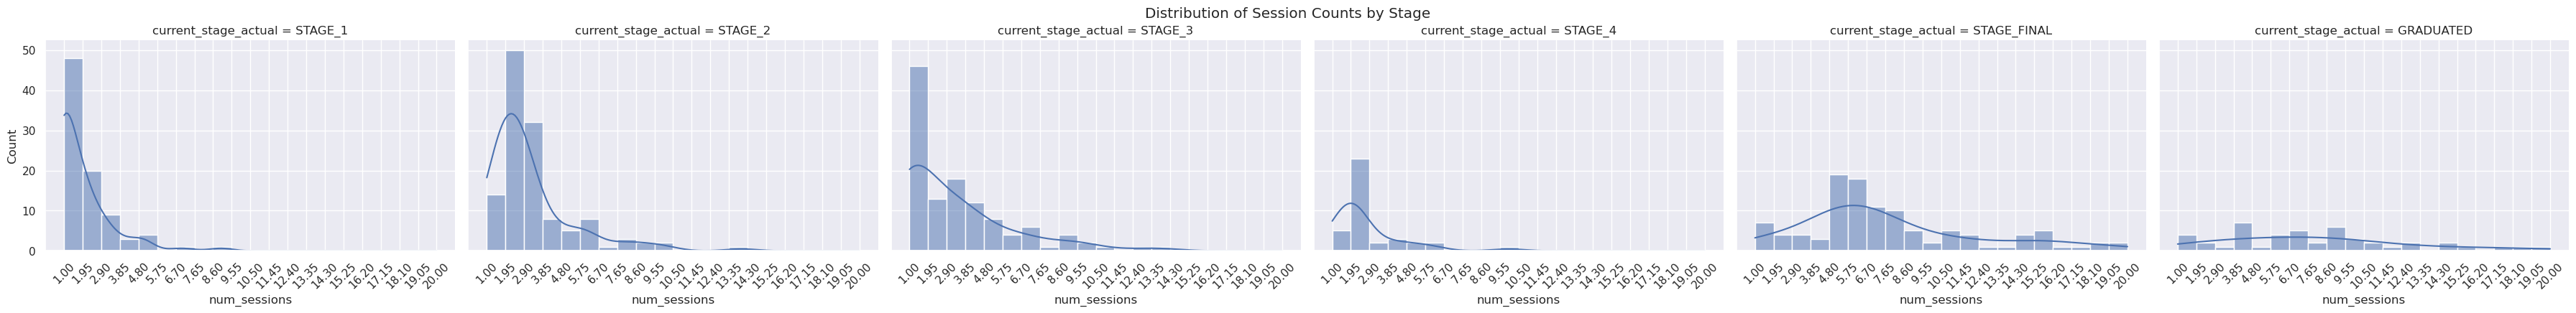

<Figure size 1200x600 with 0 Axes>

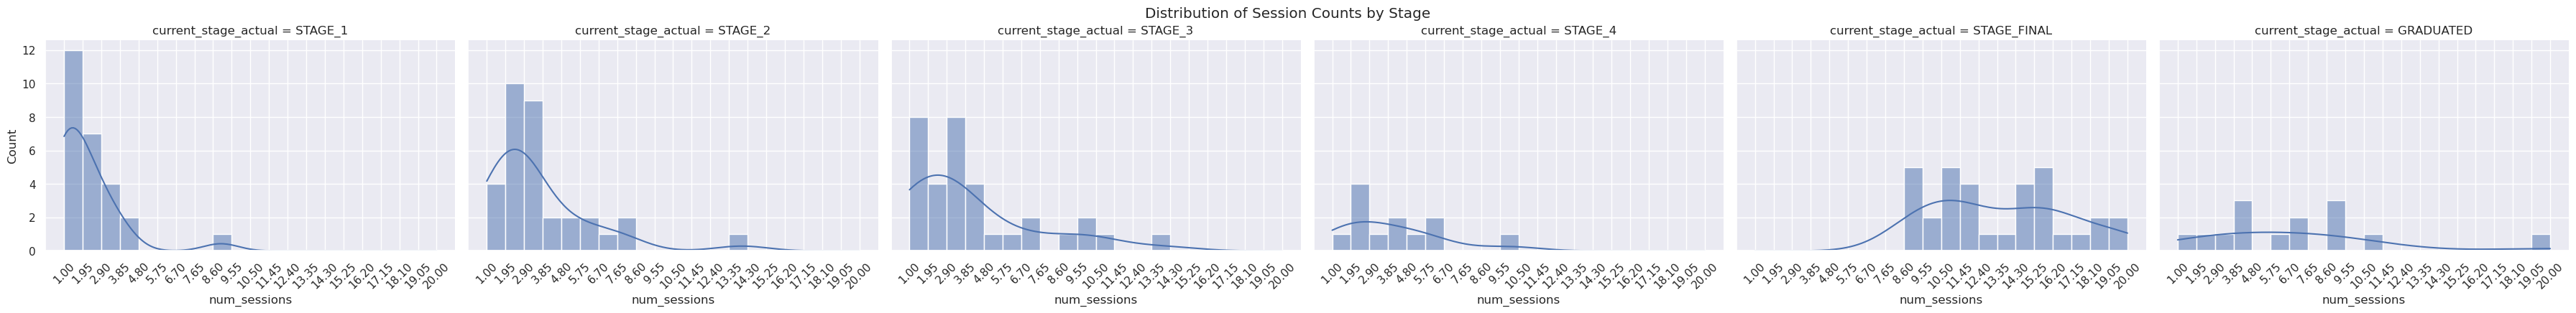

<Figure size 1200x600 with 0 Axes>

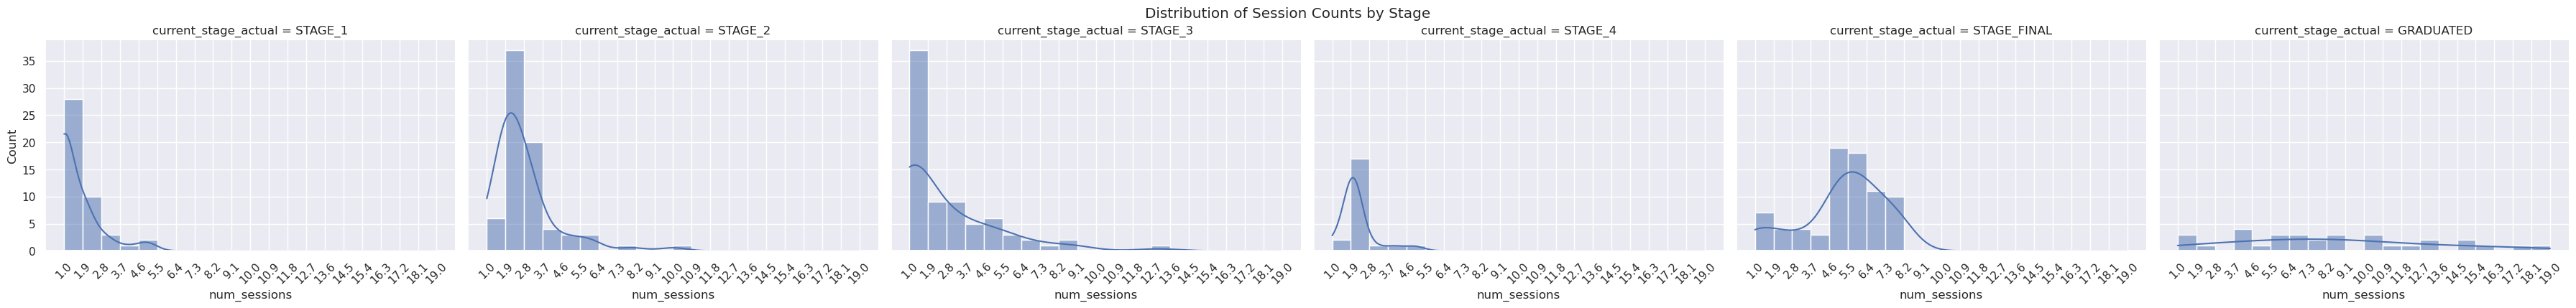

In [51]:
# Pass function to stage only DataFrame
main_results = analyze_splits(main_df, threshold = 8.25)
fast_session_main_df = main_results['fast']['df']
slow_session_main_df = main_results['slow']['df']
threshold_used = main_results['threshold']

Threshold value: 8.25 sessions
Number of slow learners 30
Number of fast learners 79


<Figure size 1200x600 with 0 Axes>

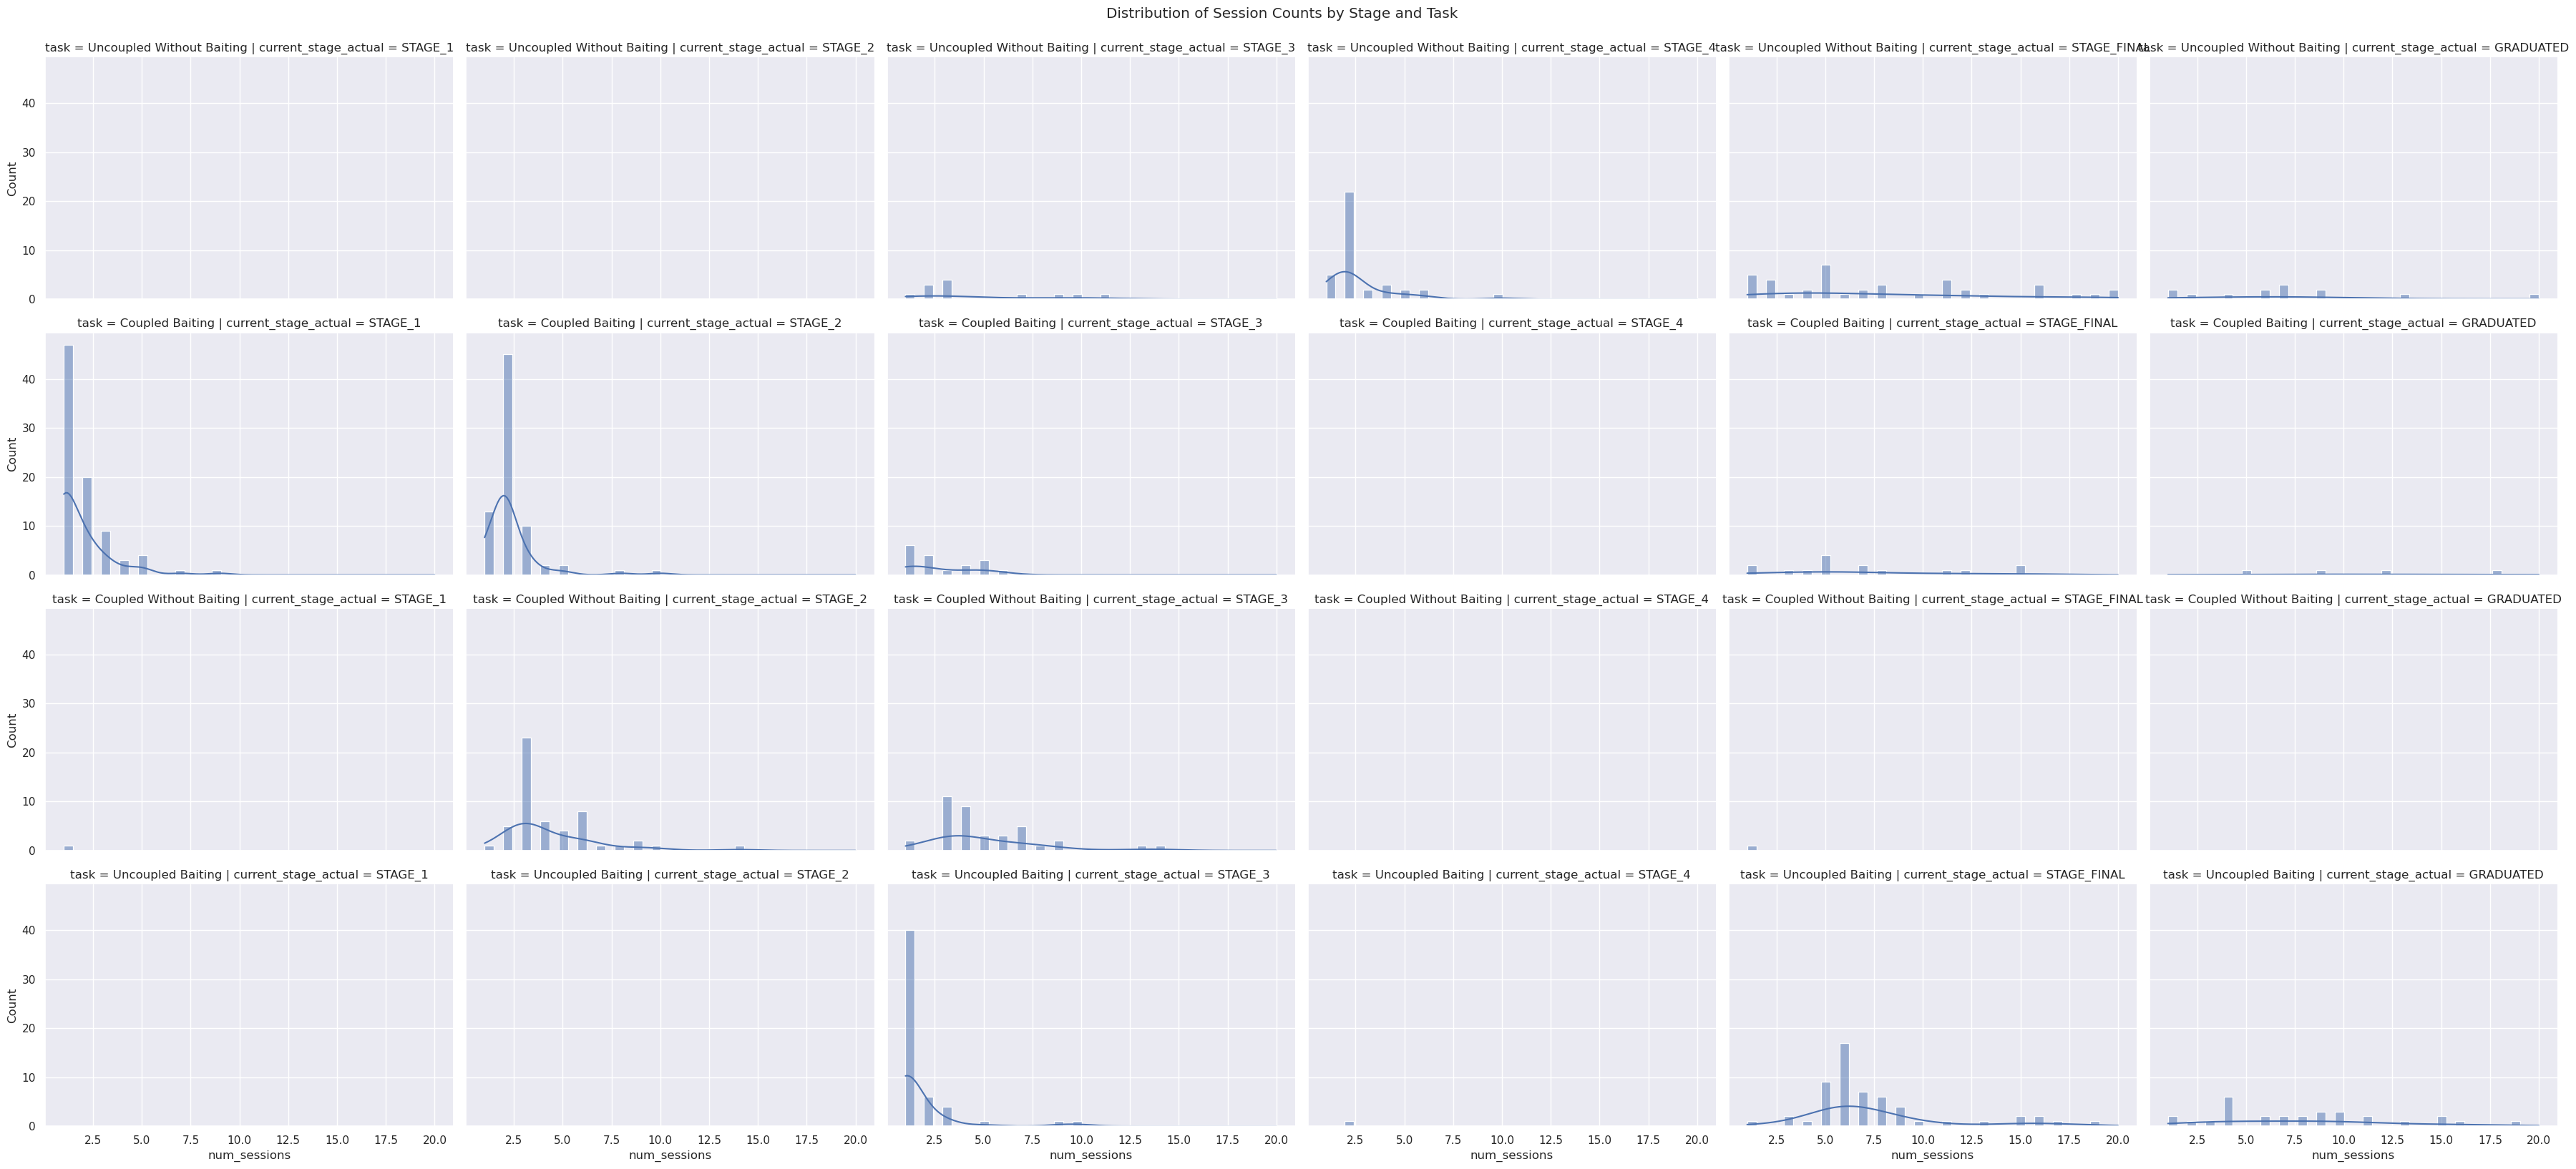

<Figure size 1200x600 with 0 Axes>

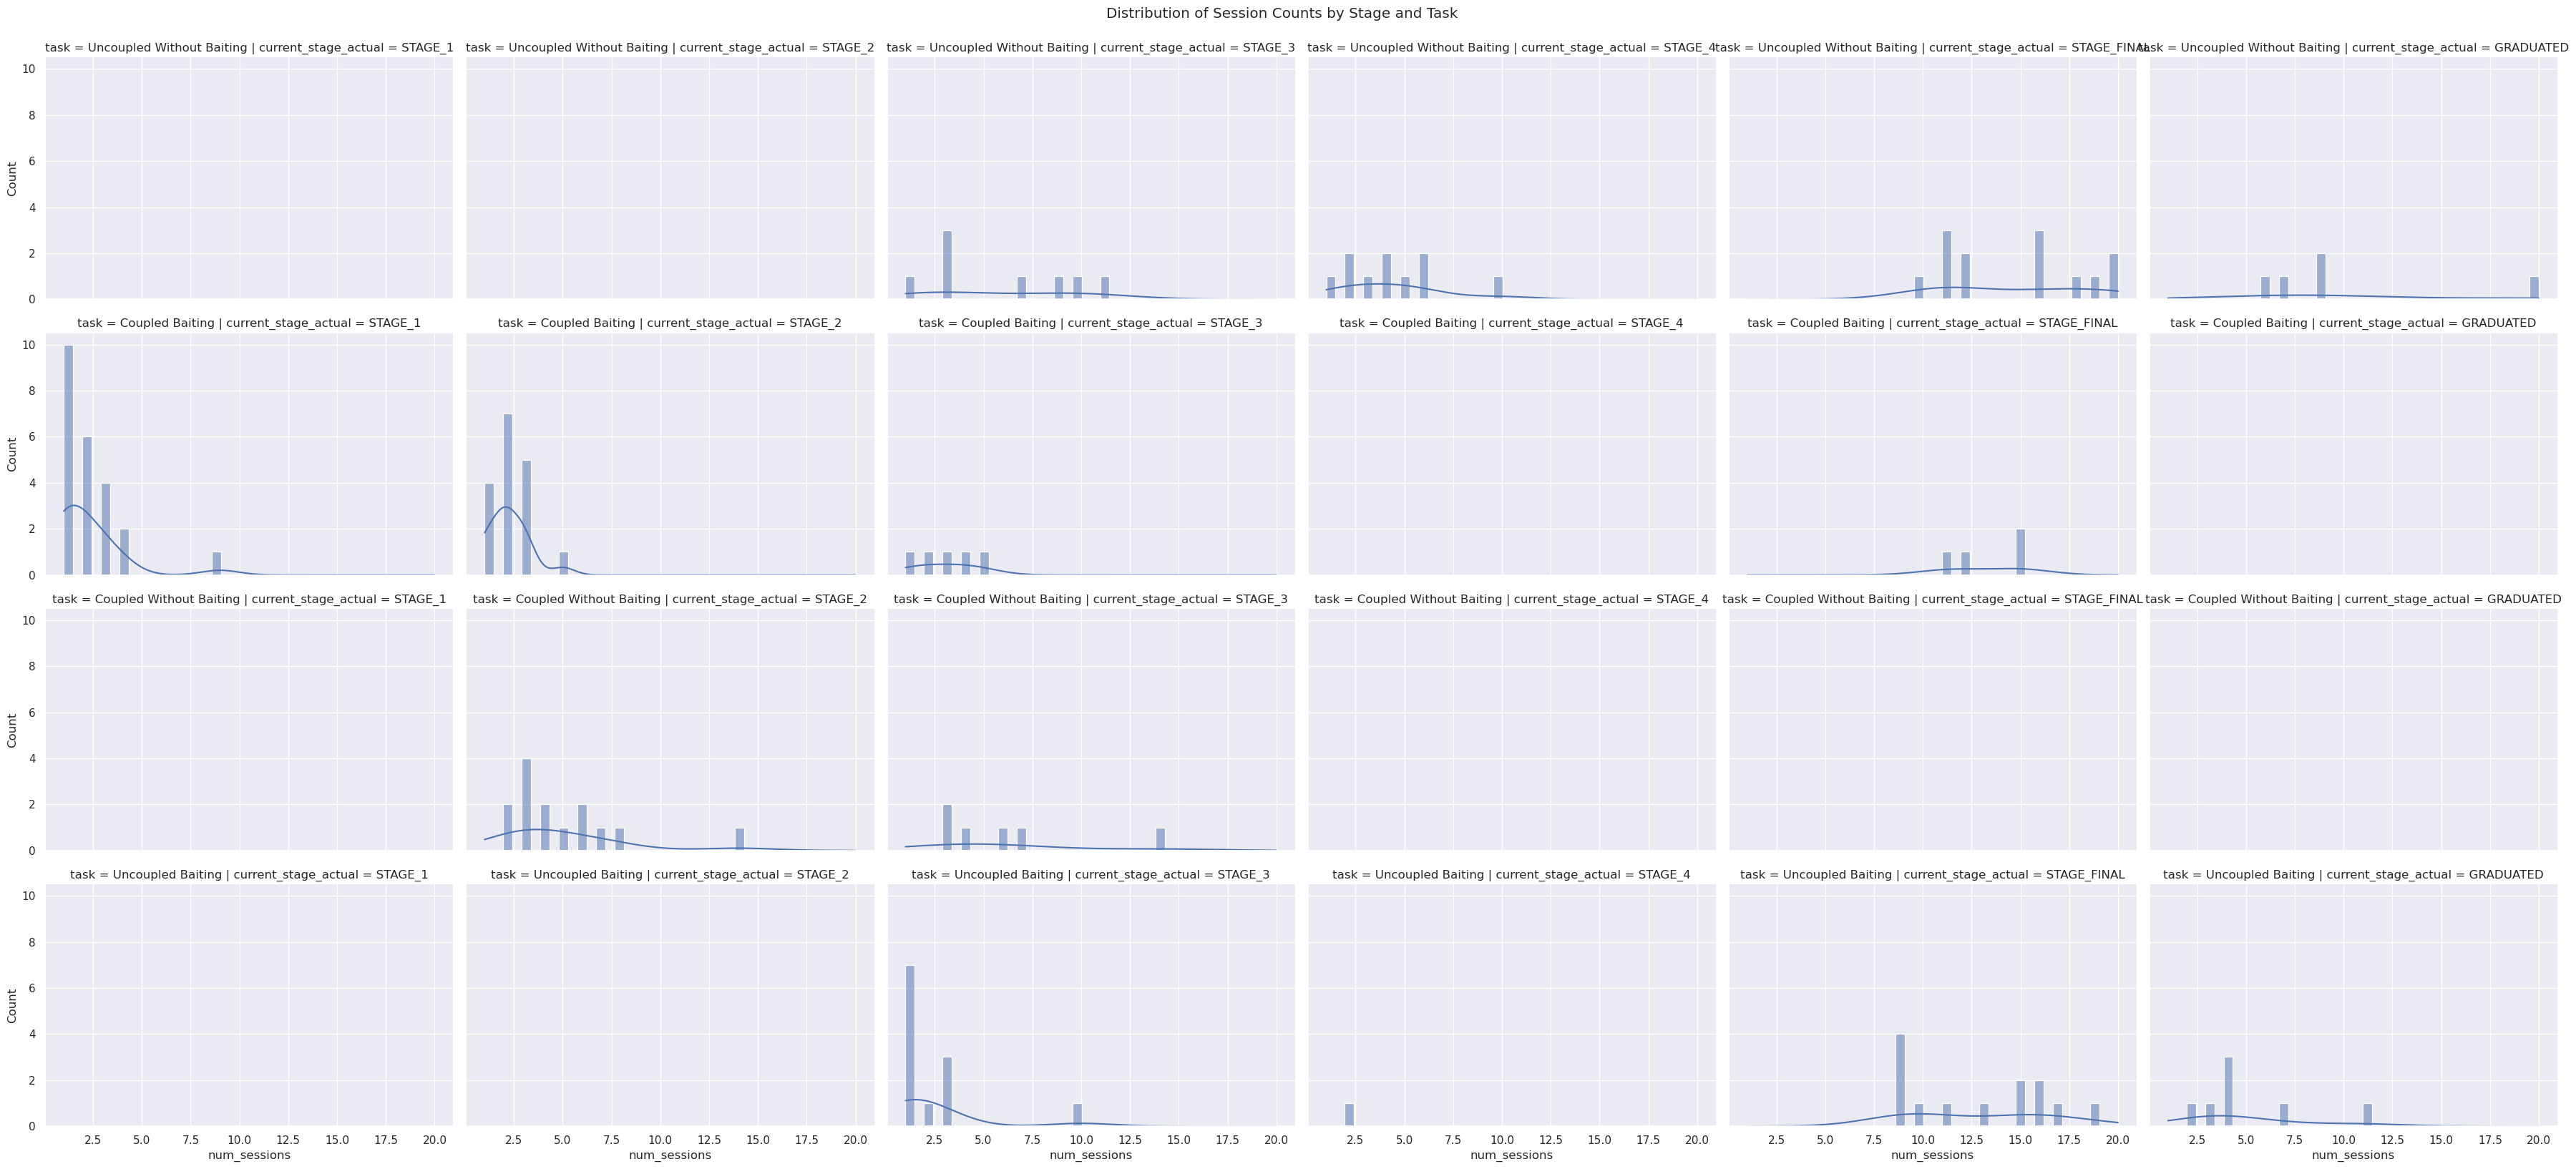

<Figure size 1200x600 with 0 Axes>

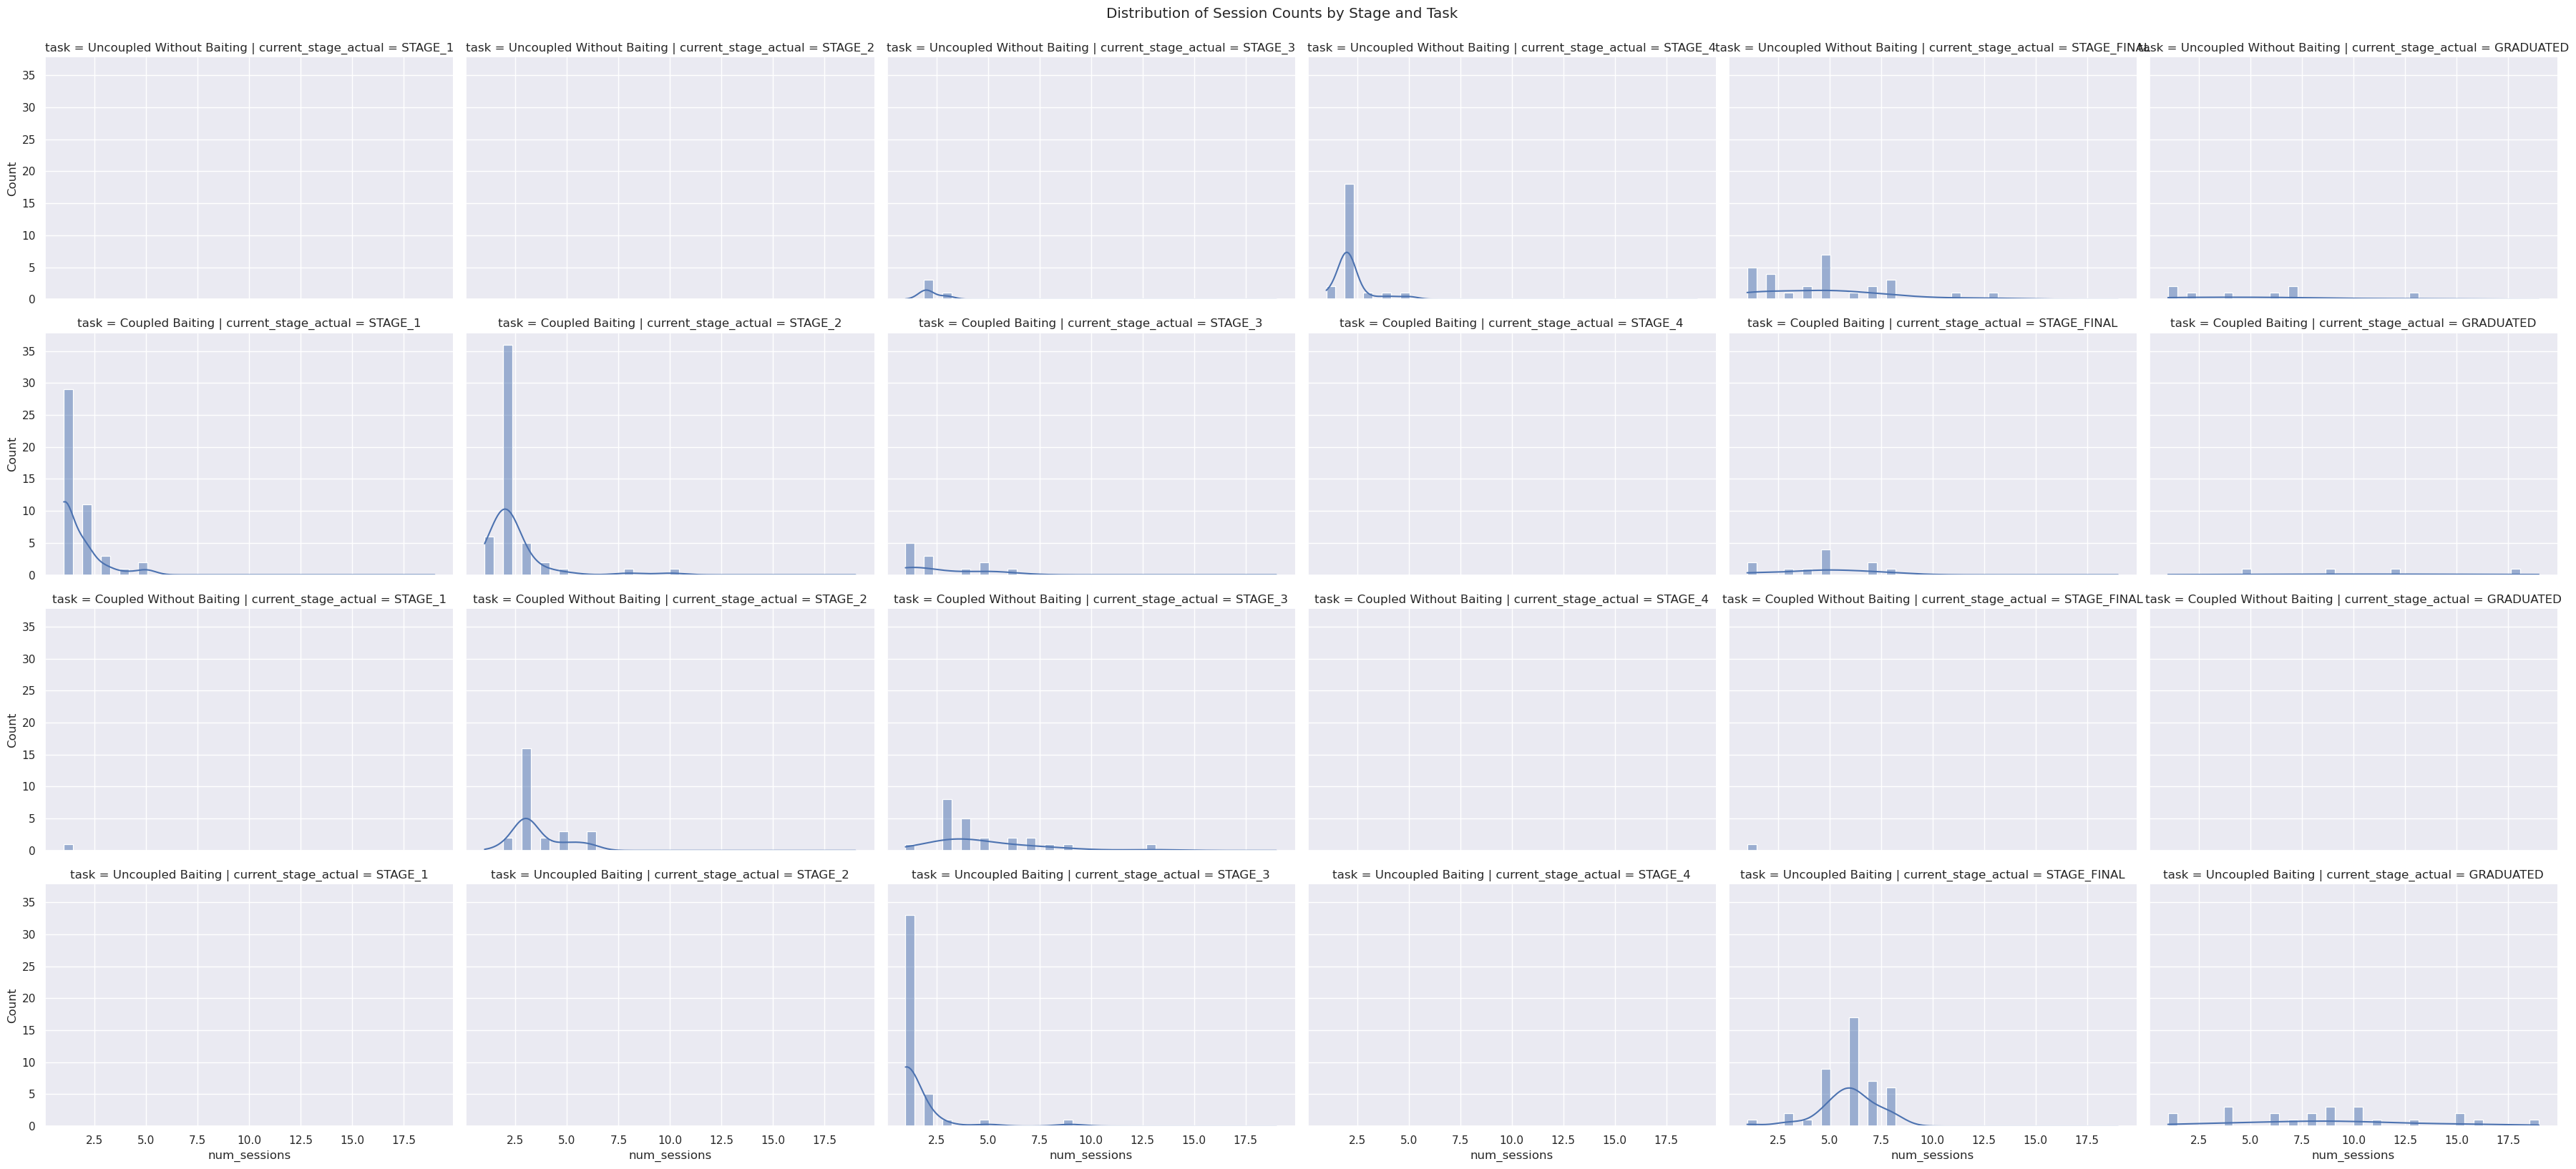

In [52]:
task_results = analyze_splits(main_task_df, task_col='task', threshold = 8.25)

slow_session_task_df = task_results['slow']['df']
fast_session_task_df = task_results['fast']['df']

In [53]:
# Summarize distribution of number of metric scores per stage

def summary_statistics(data_dict):
    summary_data = []

    for key, array in data_dict.items():
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        Q1 = np.percentile(non_nan_counts, 5)
        Q3 = np.percentile(non_nan_counts, 95)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        outliers = non_nan_counts[(non_nan_counts > upper_bound)]
        
        if isinstance(key, tuple):
            stage, task = key
        else:
            stage, task = key, "N/A"

        summary_data.append({
            'Stage': stage,
            'Task': task,
            'Array Shape': array.shape,
            'Mean': np.mean(non_nan_counts),
            'Std Dev': np.std(non_nan_counts),
            'Min': np.min(non_nan_counts),
            'Max': np.max(non_nan_counts),
            'Outliers': len(outliers)
        })

    # Create a summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df


In [54]:
# Create design matrices for all task types 

def create_stage_arrays(df, stage_col='current_stage_actual', subject_col='subject_id', metric='foraging_eff'):
    # Get unique stages and subjects

    stages = df[stage_col].unique()
    subjects = df[subject_col].unique()

    stage_arrays = {}

    for stage in stages:
        # Filter the dataframe for the current stage
        stage_df = df[df[stage_col] == stage]
        
        # Get the max number of sessions for this stage
        max_sessions = stage_df.groupby(subject_col).size().max()
        
        # For the NaN stage
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with metric scores
        for i, subject in enumerate(subjects):
            subject_data = stage_df[stage_df[subject_col] == subject][metric].values
            stage_array[i, :len(subject_data)] = subject_data
        
        stage_arrays[stage] = stage_array

    return stage_arrays

In [55]:
slow_stage_arrays = create_stage_arrays(slow_session_main_df)
summary_statistics(slow_stage_arrays)

No data found for stage nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,N/A,"(33, 20)",2.909091,4.541817,0,20,0
1,STAGE_FINAL,N/A,"(33, 20)",13.575758,3.411481,9,20,0
2,STAGE_3,N/A,"(33, 14)",4.090909,3.324506,1,14,0
3,STAGE_2,N/A,"(33, 14)",3.575758,2.640366,1,14,0
4,STAGE_1,N/A,"(33, 9)",1.666667,1.717409,0,9,0
5,STAGE_4,N/A,"(33, 10)",1.424242,2.387217,0,10,0


In [56]:
fast_stage_arrays = create_stage_arrays(fast_session_main_df)
summary_statistics(fast_stage_arrays)

No data found for stage nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_FINAL,N/A,"(76, 8)",5.250000,2.033438,1,8,0
1,GRADUATED,N/A,"(76, 19)",3.552632,5.202213,0,19,0
2,STAGE_3,N/A,"(76, 13)",2.671053,2.413712,0,13,0
3,STAGE_4,N/A,"(76, 5)",0.631579,1.086304,0,5,0
4,STAGE_2,N/A,"(76, 10)",2.723684,1.544078,0,10,0
5,STAGE_1,N/A,"(76, 5)",0.934211,1.116097,0,5,0


In [57]:
# Create design matrices for all task / stage combinations

def create_stage_task_arrays(df, stage_col='current_stage_actual', subject_col='subject_id', task_col='task', metric='foraging_eff'):

    # Get unique stage, task, subjects 
    stages = df[stage_col].unique()
    subjects = df[subject_col].unique()
    tasks = df[task_col].unique()

    # Initialize new dictionary 
    stage_task_arrays = {}

    for stage in stages:
        for task in tasks:
            # Filter the dataframe for the current stage and task
            stage_task_df = df[(df[stage_col] == stage) & (df[task_col] == task)]
            
            max_sessions = stage_task_df.groupby(subject_col).size().max()
            
            # For stages or tasks with no data
            if pd.isna(max_sessions):
                print(f"No data found for stage {stage} and task {task}")
                continue
            
            max_sessions = int(max_sessions)
            
            stage_task_array = np.full((len(subjects), max_sessions), np.nan)
            
            # Fill the array with metric scores
            for i, subject in enumerate(subjects):
                subject_data = stage_task_df[stage_task_df[subject_col] == subject][metric].values
                stage_task_array[i, :len(subject_data)] = subject_data
            
            stage_task_arrays[(stage, task)] = stage_task_array

    return stage_task_arrays

In [58]:
slow_stage_task_arrays = create_stage_task_arrays(slow_session_task_df)
summary_statistics(slow_stage_task_arrays)

No data found for stage GRADUATED and task Coupled Baiting
No data found for stage GRADUATED and task Coupled Without Baiting
No data found for stage STAGE_FINAL and task Coupled Without Baiting
No data found for stage nan and task Uncoupled Baiting
No data found for stage nan and task Uncoupled Without Baiting
No data found for stage nan and task Coupled Baiting
No data found for stage nan and task Coupled Without Baiting
No data found for stage STAGE_2 and task Uncoupled Baiting
No data found for stage STAGE_2 and task Uncoupled Without Baiting
No data found for stage STAGE_1 and task Uncoupled Baiting
No data found for stage STAGE_1 and task Uncoupled Without Baiting
No data found for stage STAGE_1 and task Coupled Without Baiting
No data found for stage STAGE_4 and task Coupled Baiting
No data found for stage STAGE_4 and task Coupled Without Baiting


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,Uncoupled Baiting,"(30, 11)",1.166667,2.517715,0,11,0
1,GRADUATED,Uncoupled Without Baiting,"(30, 20)",1.700000,4.321651,0,20,0
2,STAGE_FINAL,Uncoupled Baiting,"(30, 19)",5.600000,6.795096,0,19,0
3,STAGE_FINAL,Uncoupled Without Baiting,"(30, 20)",6.400000,7.692421,0,20,0
4,STAGE_FINAL,Coupled Baiting,"(30, 15)",1.766667,4.551068,0,15,0
5,STAGE_3,Uncoupled Baiting,"(30, 10)",0.933333,1.931033,0,10,1
6,STAGE_3,Uncoupled Without Baiting,"(30, 11)",1.566667,3.190437,0,11,0
7,STAGE_3,Coupled Baiting,"(30, 5)",0.500000,1.258306,0,5,0
8,STAGE_3,Coupled Without Baiting,"(30, 14)",1.233333,2.996479,0,14,0
9,STAGE_2,Coupled Baiting,"(30, 5)",1.266667,1.339983,0,5,0


In [59]:
fast_stage_task_arrays = create_stage_task_arrays(fast_session_task_df)
summary_statistics(fast_stage_task_arrays)

No data found for stage nan and task Uncoupled Baiting
No data found for stage nan and task Uncoupled Without Baiting
No data found for stage nan and task Coupled Without Baiting
No data found for stage nan and task Coupled Baiting
No data found for stage GRADUATED and task Coupled Without Baiting
No data found for stage STAGE_4 and task Uncoupled Baiting
No data found for stage STAGE_4 and task Coupled Without Baiting
No data found for stage STAGE_4 and task Coupled Baiting
No data found for stage STAGE_2 and task Uncoupled Baiting
No data found for stage STAGE_2 and task Uncoupled Without Baiting
No data found for stage STAGE_1 and task Uncoupled Baiting
No data found for stage STAGE_1 and task Uncoupled Without Baiting


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_FINAL,Uncoupled Baiting,"(79, 8)",3.227848,3.133928,0,8,0
1,STAGE_FINAL,Uncoupled Without Baiting,"(79, 13)",1.607595,2.865852,0,13,0
2,STAGE_FINAL,Coupled Without Baiting,"(79, 1)",0.012658,0.111794,0,1,1
3,STAGE_FINAL,Coupled Baiting,"(79, 8)",0.645570,1.800408,0,8,0
4,GRADUATED,Uncoupled Baiting,"(79, 19)",2.468354,4.662904,0,19,0
5,GRADUATED,Uncoupled Without Baiting,"(79, 13)",0.518987,1.960759,0,13,1
6,GRADUATED,Coupled Baiting,"(79, 18)",0.556962,2.637350,0,18,4
7,STAGE_3,Uncoupled Baiting,"(79, 9)",0.759494,1.244890,0,9,1
8,STAGE_3,Uncoupled Without Baiting,"(79, 3)",0.113924,0.502836,0,3,4
9,STAGE_3,Coupled Without Baiting,"(79, 13)",1.405063,2.592682,0,13,0


In [60]:
# Function to adjust outliers in each stage (No use)

def remove_outliers_n(data_dict, n):
    result = {}

    for key, array in data_dict.items():

        if isinstance(key, tuple):
            stage, task = key
        else:
            stage = key
            task = None

        # Count num of fe values in each row
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        # Sort rows by their fe counts
        sorted_indices = np.argsort(non_nan_counts)[::-1]
        sorted_counts = non_nan_counts[sorted_indices]
        
        # Find the cutoff point
        if len(sorted_counts) > n:
            cutoff = sorted_counts[n]
        else:
            cutoff = sorted_counts[-1]
        
        # Create a mask for rows to keep
        keep_mask = non_nan_counts <= cutoff
        
        # Create make for rows to trim
        trim_mask = non_nan_counts > cutoff
        
        new_array = np.full((array.shape[0], cutoff), np.nan)
        
        # Fill in the rows that are kept
        new_array[keep_mask] = array[keep_mask][:, :cutoff]
        
        # Fill in the trimmed rows
        for i in np.where(trim_mask)[0]:
            non_nan_indices = np.where(~np.isnan(array[i]))[0][:cutoff]
            new_array[i, :len(non_nan_indices)] = array[i, non_nan_indices]
        
        if task is not None:
            result[(stage, task)] = new_array
        else:
            result[stage] = new_array
    
    return result


In [61]:
# Set prefrence for outlier removal (no use)

n = 1
n1 = 1


# Non-task specific dict 
slow_filtered_arrays = remove_outliers_n(slow_stage_arrays, n)
fast_filtered_arrays = remove_outliers_n(fast_stage_arrays, n)

# Task specific dict
slow_filtered_task_arrays = remove_outliers_n(slow_stage_task_arrays, n1)
fast_filtered_task_arrays = remove_outliers_n(fast_stage_task_arrays, n1)

In [62]:
# Create heatmap for visualization of an example array in stage only dictionary 

def plot_array_heatmap(array, stage):
    plt.figure(figsize=(16,5))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.show()

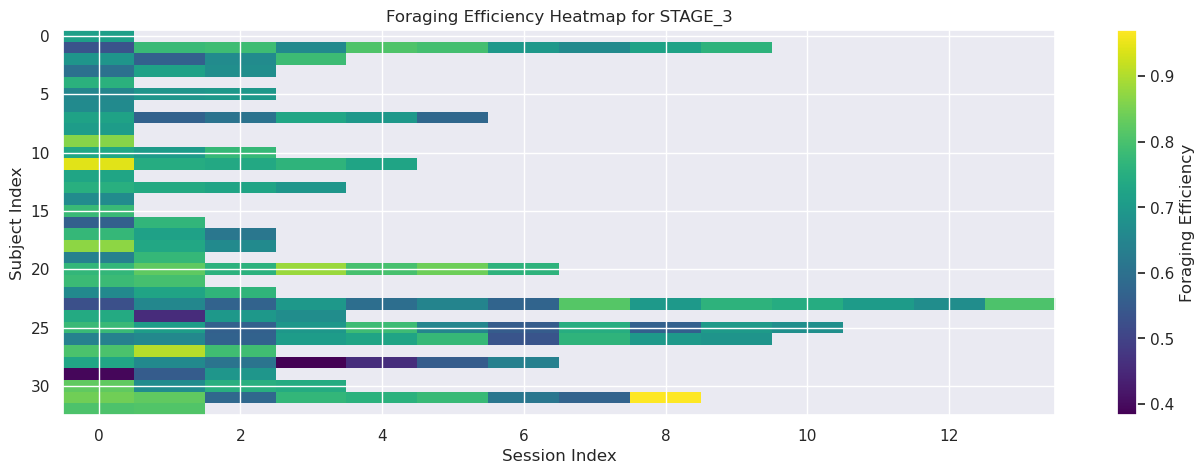

In [63]:
plot_array_heatmap(slow_stage_arrays['STAGE_3'], 'STAGE_3')

In [64]:
def calculate_average_vectors(data_dict):
    averages = {}

    if isinstance(next(iter(data_dict.keys())), tuple):
        # Stage task dictionary
        for (stage, task), array in data_dict.items():
            if stage not in averages:
                averages[stage] = {}
            averages[stage][task] = np.nanmean(array, axis=0)
    else:
        # Stage dictionary
        for stage, array in data_dict.items():
            averages[stage] = np.nanmean(array, axis=0)

    # Find the average vectors
    for stage, value in averages.items():
        print(f"\nAverage foraging efficiency for stage {stage}:")
        if isinstance(value, dict):
            for task, average_vector in value.items():
                print(f" \n Task: {task}")
                print(f" \n Average vector: {average_vector}")
                print(f" \n Shape: {average_vector.shape}")
        else:
            print(f"Average vector: {value}")
            print(f"Shape: {value.shape}")

    return averages

In [65]:
stage_averages = calculate_average_vectors(slow_stage_arrays)
stage_task_averages = calculate_average_vectors(fast_stage_arrays)


Average foraging efficiency for stage GRADUATED:
Average vector: [0.72801273 0.73528235 0.75270959 0.76612219 0.72167843 0.70835297
 0.72329126 0.74446357 0.82923485 0.83317297 0.77134355 0.6557377
 0.72929543 0.78263131 0.48275862 0.7423231  0.69954128 0.81129096
 0.71837585 0.7199186 ]
Shape: (20,)

Average foraging efficiency for stage STAGE_FINAL:
Average vector: [0.77288381 0.72417937 0.72794714 0.75260945 0.76921324 0.74410139
 0.7326533  0.72656004 0.7197778  0.76297803 0.74364138 0.69507172
 0.73437633 0.74702782 0.72271303 0.74801972 0.73812601 0.70801782
 0.77742571 0.60848542]
Shape: (20,)

Average foraging efficiency for stage STAGE_3:
Average vector: [0.71733497 0.71078706 0.68092885 0.70638526 0.70586257 0.70282417
 0.62490829 0.71309566 0.73142453 0.72911659 0.71138497 0.70601852
 0.67132538 0.80672022]
Shape: (14,)

Average foraging efficiency for stage STAGE_2:
Average vector: [0.73396803 0.71265284 0.70368078 0.69469735 0.61455966 0.64878886
 0.6787775  0.66560994 0.

In [66]:
# Plot function for foraging efficiency over stages 


def plot_foraging_efficiency(data_dict, stage_sequence, ylabel='Foraging Efficiency'):
    is_stage_task = isinstance(next(iter(data_dict.keys())), tuple)
    
    # Choose between task/stage dictionary and stage dictionary 
    if is_stage_task:
        tasks = list(set(task for _, task in data_dict.keys()))
    else:
        tasks = ['']
    
    for task in tasks:
        data = []
        subject_data = []
        overall_session = 0

        for stage in stage_sequence:
            if is_stage_task:
                if (stage, task) in data_dict:
                    stage_data = data_dict[(stage, task)]
                else:
                    continue
            else:
                if stage in data_dict:
                    stage_data = data_dict[stage]
                else:
                    continue

            num_sessions = stage_data.shape[1]
            num_subjects = stage_data.shape[0]
            
            for session in range(num_sessions):
                session_data = stage_data[:, session]
                mean = np.nanmean(session_data)
                std = np.nanstd(session_data)
                
                data.append({
                    'Stage': stage,
                    'Session': overall_session,
                    'Stage Session': session,
                    'Mean': mean,
                    'Std': std
                })
                
                for subject in range(num_subjects):
                    subject_data.append({
                        'Stage': stage,
                        'Session': overall_session,
                        'Stage Session': session,
                        'Subject': subject,
                        'Score': stage_data[subject, session]
                    })

                overall_session += 1

        stage_plot_df = pd.DataFrame(data)
        subject_plot_df = pd.DataFrame(subject_data)

        plt.figure(figsize=(20, 6))

        sns.scatterplot(x='Session', y='Score', data=subject_plot_df, alpha=0.2, color='grey', legend=False)
        sns.lineplot(x='Session', y='Mean', data=stage_plot_df)


        plt.fill_between(stage_plot_df['Session'], 
                        stage_plot_df['Mean'] - stage_plot_df['Std'], 
                        stage_plot_df['Mean'] + stage_plot_df['Std'], 
                        alpha=0.2, color='b')

        plt.xlabel('Session (across all stages)', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)

        stage_boundaries = [stage_plot_df[stage_plot_df['Stage'] == stage]['Session'].min() 
                            for stage in stage_sequence if stage in stage_plot_df['Stage'].unique()]
        for boundary in stage_boundaries[1:]:
            plt.axvline(x=boundary - 0.5, color='b', linestyle='--', alpha=0.5)

        xticks = []
        xticklabels = []
        for i, stage in enumerate(stage_sequence):
            if stage in stage_plot_df['Stage'].unique():
                stage_sessions = stage_plot_df[stage_plot_df['Stage'] == stage]['Session']
                stage_start = stage_sessions.min()
                stage_end = stage_sessions.max()
                stage_ticks = range(int(stage_start), int(stage_end) + 1, 4)
                xticks.extend(stage_ticks)
                xticklabels.extend(range(0, (len(stage_ticks) - 1) * 4 + 1, 4))

                mid_point = (stage_start + stage_end) / 2
                plt.text(mid_point, plt.ylim()[1], stage, horizontalalignment='center', verticalalignment='bottom')

        plt.xticks(xticks, xticklabels)
        plt.xticks(ha='right')

        plt.plot([], [], color='grey', alpha=0.2, linewidth=0, marker='o', markersize=10, label='Subject Scores')

        if is_stage_task:
            plt.plot([], [], color='blue', linewidth=2, label=f'{task} Mean Score')
        else:
            plt.plot([], [], color='blue', linewidth=2, label='All Task Mean Score')
        
        plt.fill_between([], [], alpha=0.2, label='Standard Deviation')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"\nStatistics for {'Task: ' + task if is_stage_task else 'All Tasks'}:")
        for stage in stage_sequence:
            if stage in stage_plot_df['Stage'].unique():
                stage_data = stage_plot_df[stage_plot_df['Stage'] == stage]
                print(f'\n{stage}:')
                print(f'Number of Sessions: {len(stage_data)}')
                print(f"Mean {ylabel}: {stage_data['Mean'].mean():.2f}")
                print(f"Standard deviation: {stage_data['Mean'].std():.2f}")
                print(f"Min efficiency: {stage_data['Mean'].min():.2f}")
                print(f"Max efficiency: {stage_data['Mean'].max():.2f}")

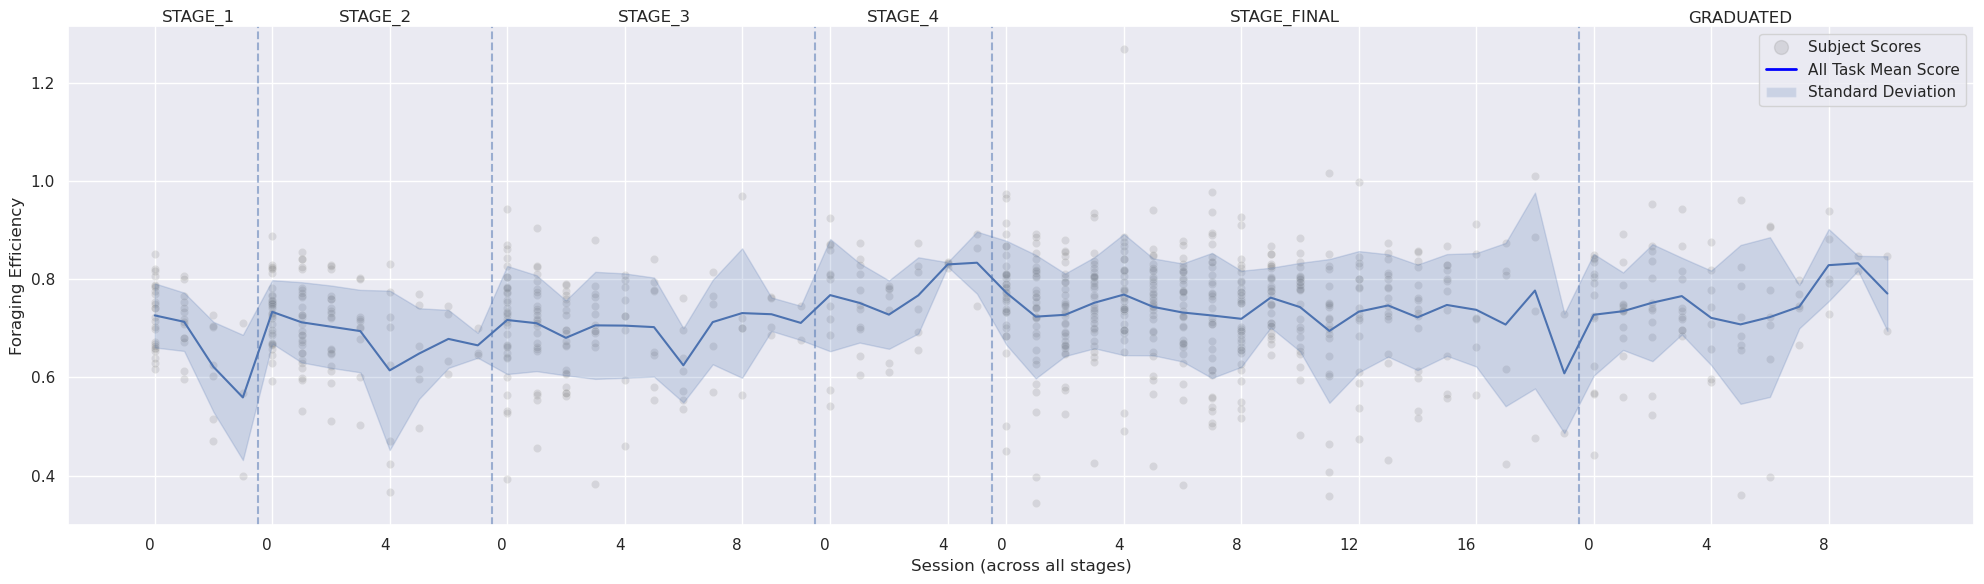


Statistics for All Tasks:

STAGE_1:
Number of Sessions: 4
Mean Foraging Efficiency: 0.66
Standard deviation: 0.08
Min efficiency: 0.56
Max efficiency: 0.73

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.68
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.73

STAGE_3:
Number of Sessions: 11
Mean Foraging Efficiency: 0.70
Standard deviation: 0.03
Min efficiency: 0.62
Max efficiency: 0.73

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency: 0.78
Standard deviation: 0.04
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 20
Mean Foraging Efficiency: 0.73
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.78

GRADUATED:
Number of Sessions: 11
Mean Foraging Efficiency: 0.76
Standard deviation: 0.04
Min efficiency: 0.71
Max efficiency: 0.83


In [67]:
stage_sequence = ['STAGE_1_WARMUP', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

# Plot slow learners stage only
plot_foraging_efficiency(slow_filtered_arrays, stage_sequence)

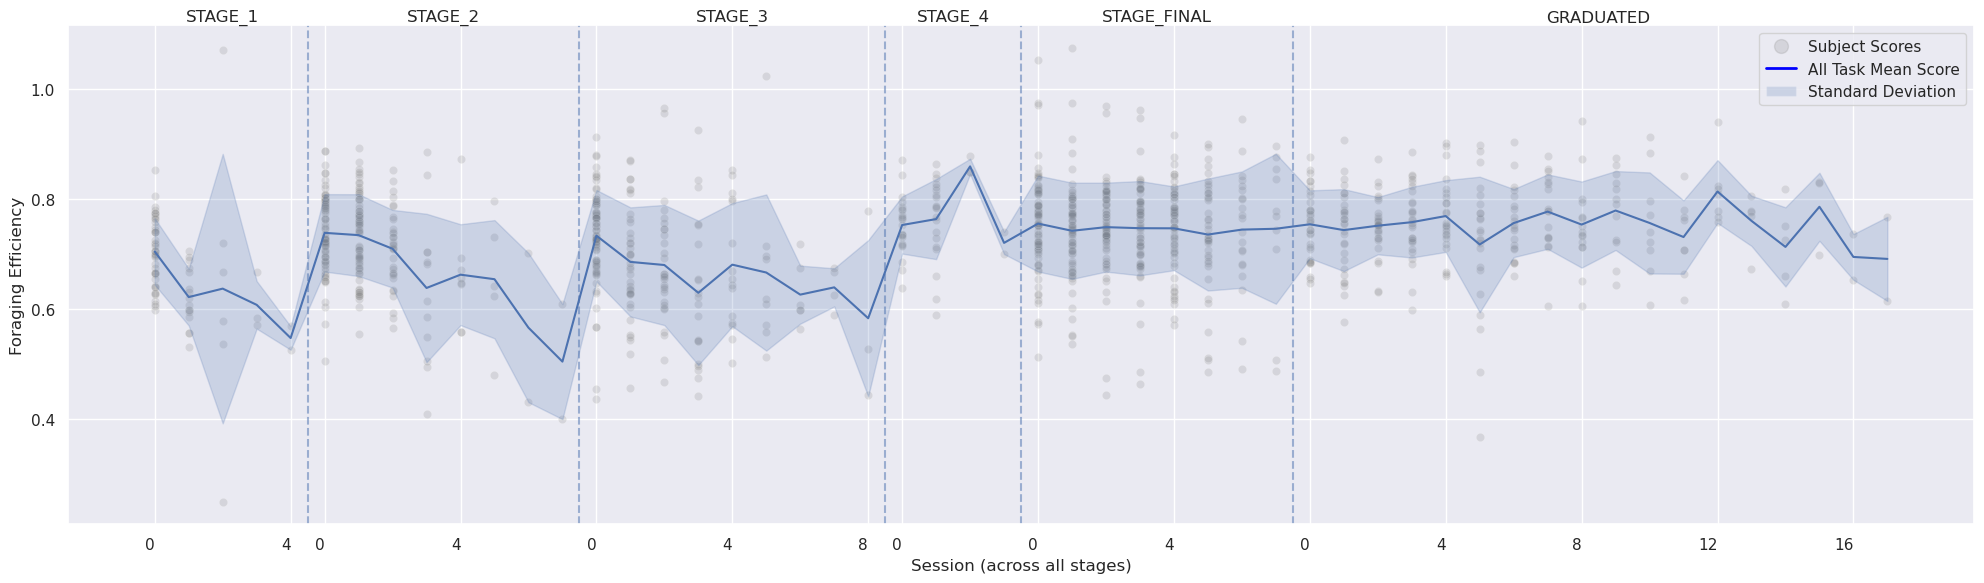


Statistics for All Tasks:

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.62
Standard deviation: 0.06
Min efficiency: 0.55
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.65
Standard deviation: 0.08
Min efficiency: 0.50
Max efficiency: 0.74

STAGE_3:
Number of Sessions: 9
Mean Foraging Efficiency: 0.66
Standard deviation: 0.04
Min efficiency: 0.58
Max efficiency: 0.73

STAGE_4:
Number of Sessions: 4
Mean Foraging Efficiency: 0.77
Standard deviation: 0.06
Min efficiency: 0.72
Max efficiency: 0.86

STAGE_FINAL:
Number of Sessions: 8
Mean Foraging Efficiency: 0.75
Standard deviation: 0.01
Min efficiency: 0.74
Max efficiency: 0.76

GRADUATED:
Number of Sessions: 18
Mean Foraging Efficiency: 0.75
Standard deviation: 0.03
Min efficiency: 0.69
Max efficiency: 0.81


In [68]:
# Plot fast learners stage only
plot_foraging_efficiency(fast_filtered_arrays, stage_sequence)

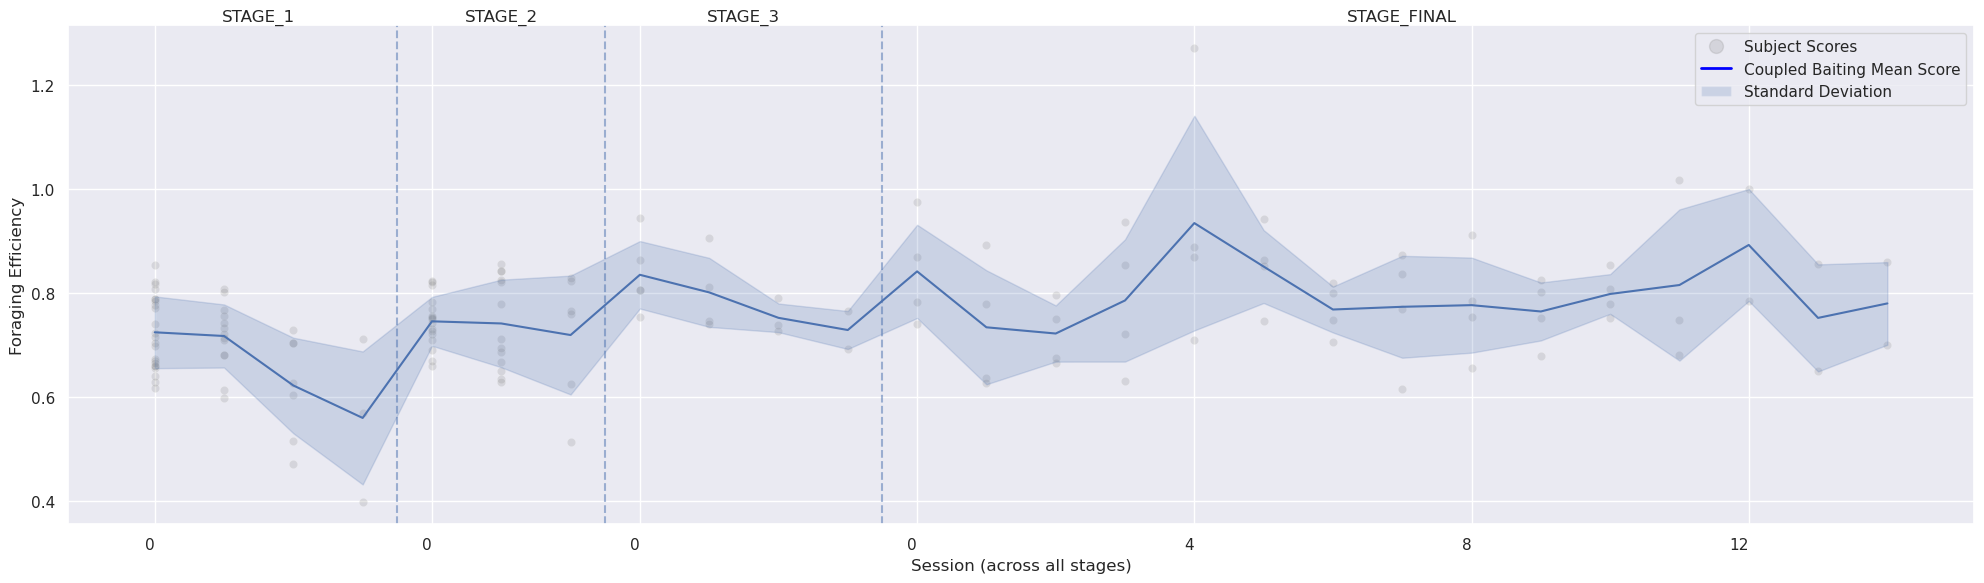


Statistics for Task: Coupled Baiting:

STAGE_1:
Number of Sessions: 4
Mean Foraging Efficiency: 0.66
Standard deviation: 0.08
Min efficiency: 0.56
Max efficiency: 0.72

STAGE_2:
Number of Sessions: 3
Mean Foraging Efficiency: 0.73
Standard deviation: 0.01
Min efficiency: 0.72
Max efficiency: 0.75

STAGE_3:
Number of Sessions: 4
Mean Foraging Efficiency: 0.78
Standard deviation: 0.05
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 15
Mean Foraging Efficiency: 0.80
Standard deviation: 0.06
Min efficiency: 0.72
Max efficiency: 0.93


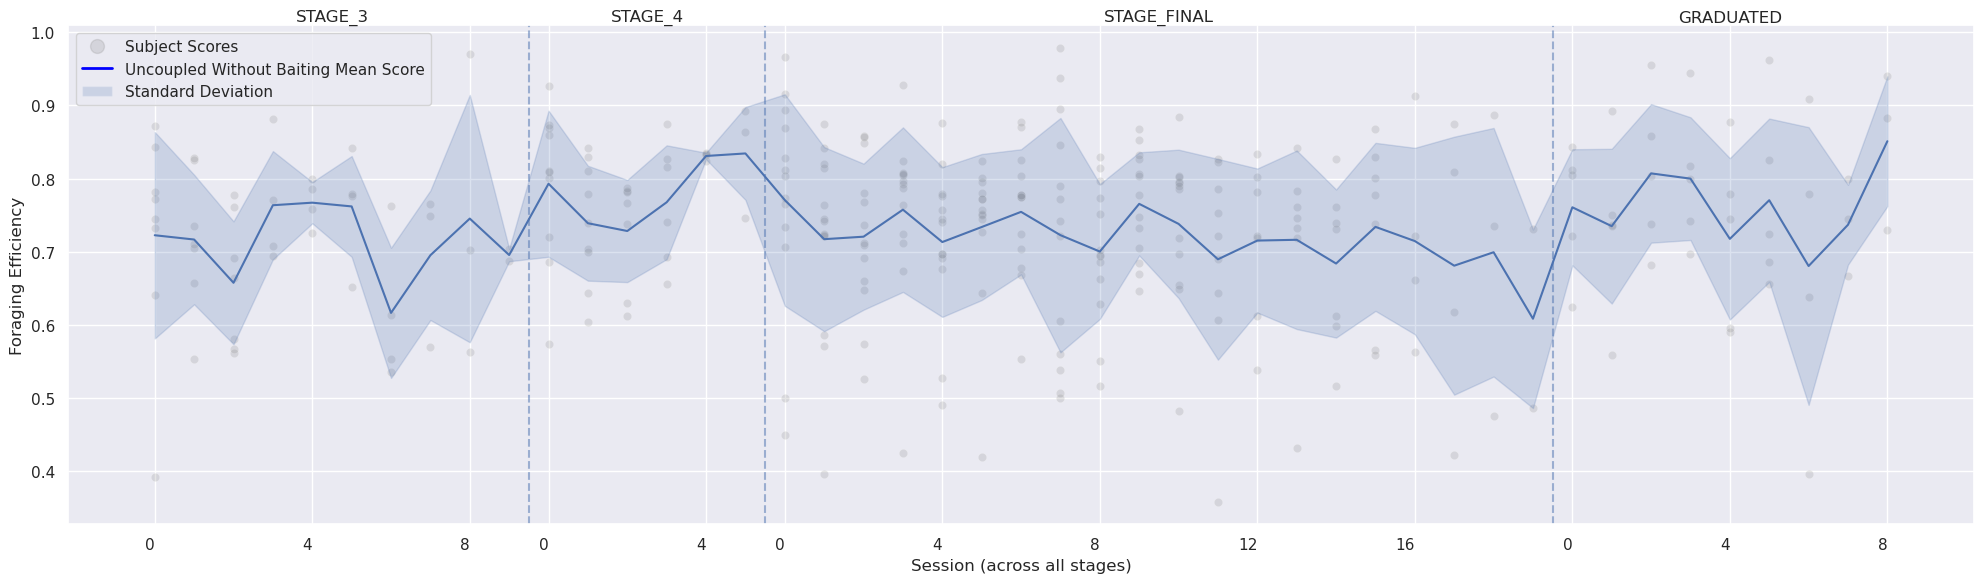


Statistics for Task: Uncoupled Without Baiting:

STAGE_3:
Number of Sessions: 10
Mean Foraging Efficiency: 0.71
Standard deviation: 0.05
Min efficiency: 0.62
Max efficiency: 0.77

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency: 0.78
Standard deviation: 0.05
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 20
Mean Foraging Efficiency: 0.72
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.77

GRADUATED:
Number of Sessions: 9
Mean Foraging Efficiency: 0.76
Standard deviation: 0.05
Min efficiency: 0.68
Max efficiency: 0.85


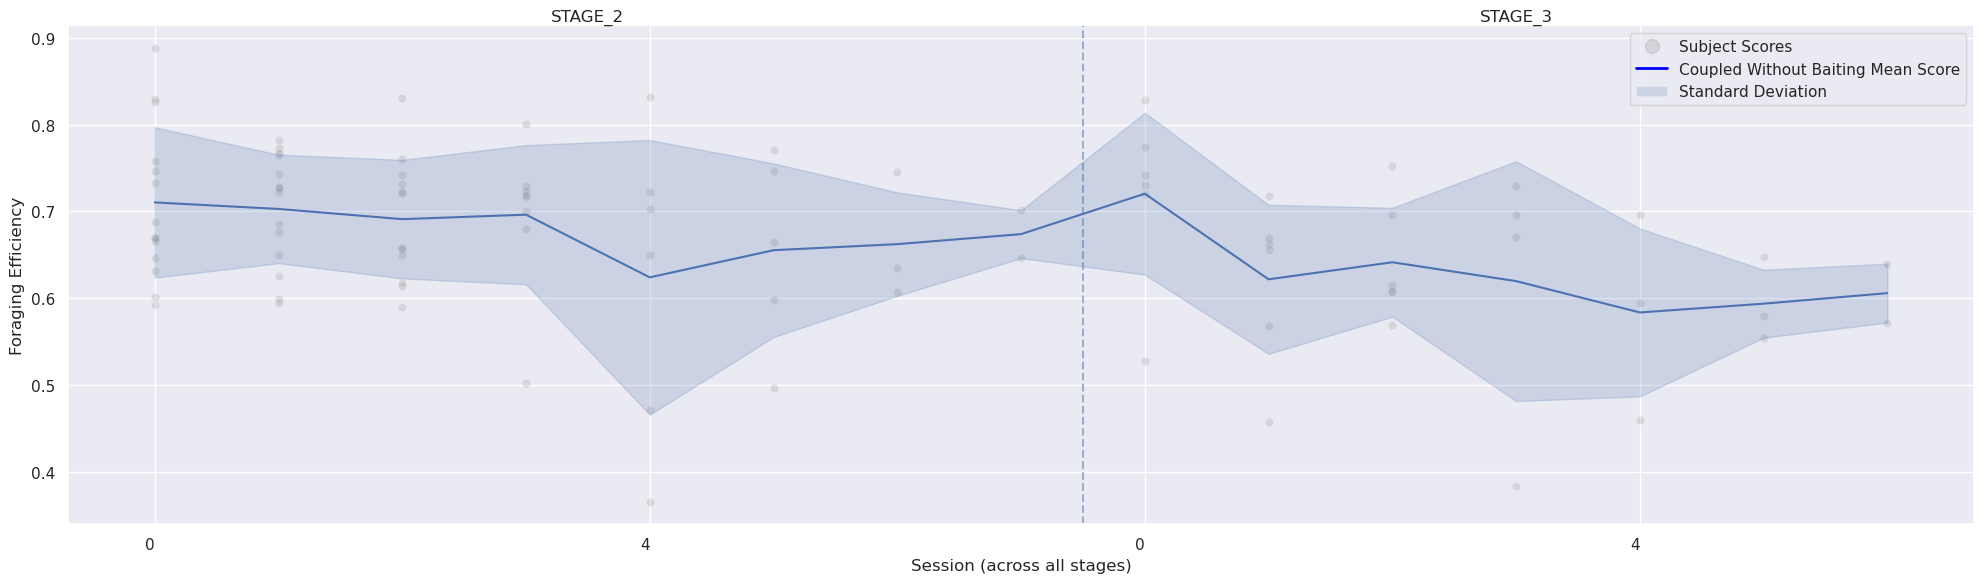


Statistics for Task: Coupled Without Baiting:

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.68
Standard deviation: 0.03
Min efficiency: 0.62
Max efficiency: 0.71

STAGE_3:
Number of Sessions: 7
Mean Foraging Efficiency: 0.63
Standard deviation: 0.05
Min efficiency: 0.58
Max efficiency: 0.72


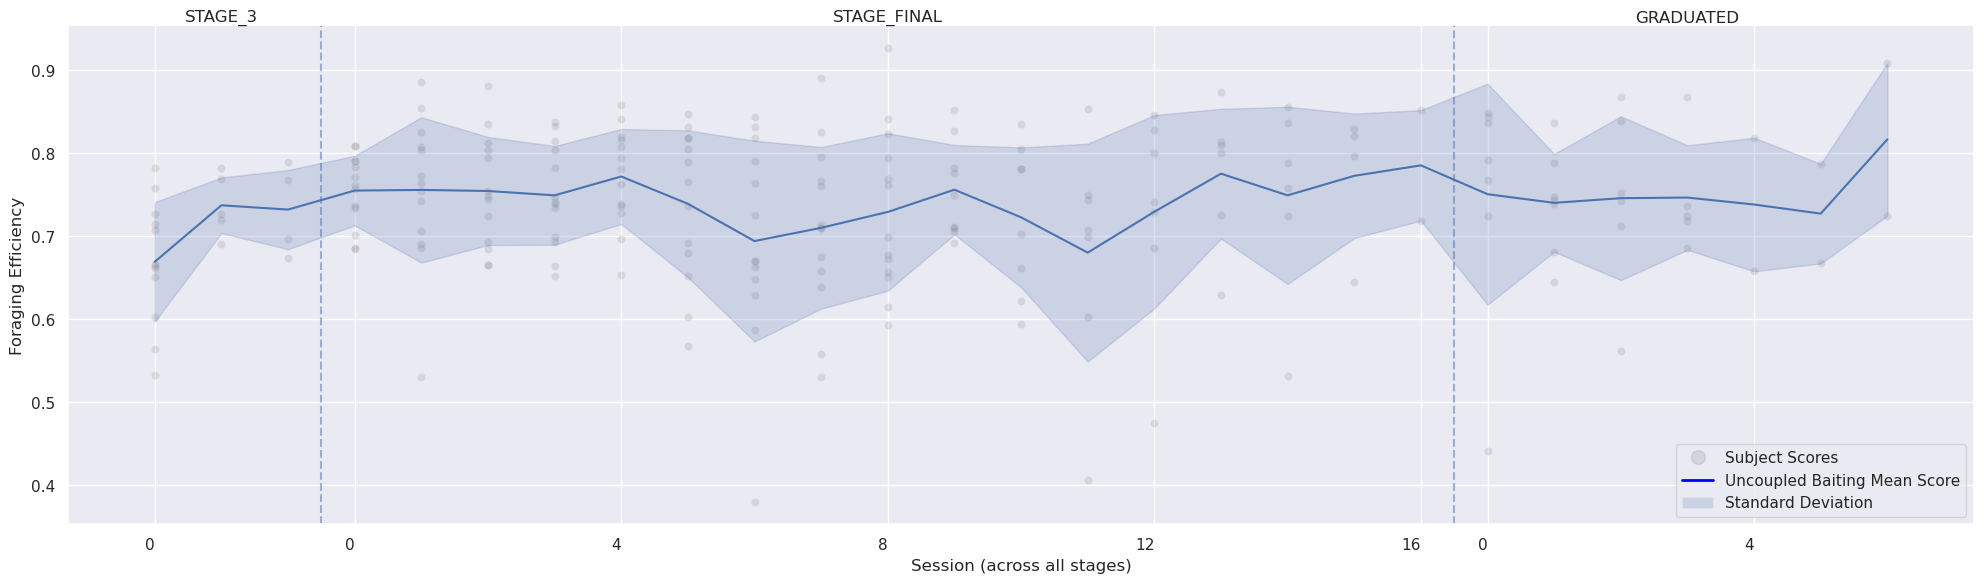


Statistics for Task: Uncoupled Baiting:

STAGE_3:
Number of Sessions: 3
Mean Foraging Efficiency: 0.71
Standard deviation: 0.04
Min efficiency: 0.67
Max efficiency: 0.74

STAGE_FINAL:
Number of Sessions: 17
Mean Foraging Efficiency: 0.74
Standard deviation: 0.03
Min efficiency: 0.68
Max efficiency: 0.79

GRADUATED:
Number of Sessions: 7
Mean Foraging Efficiency: 0.75
Standard deviation: 0.03
Min efficiency: 0.73
Max efficiency: 0.82


In [69]:
# Plot slow learners stage and task
plot_foraging_efficiency(slow_filtered_task_arrays, stage_sequence)

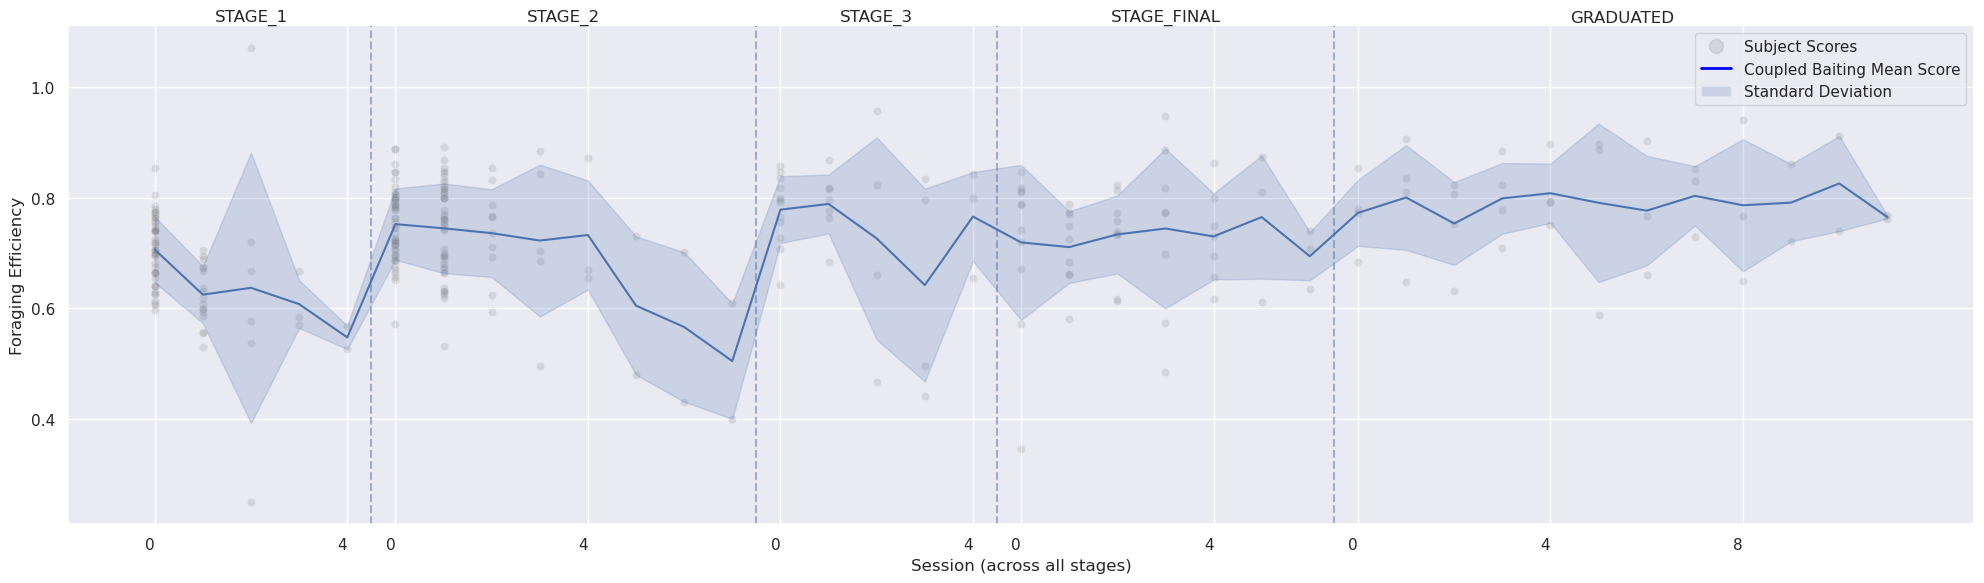


Statistics for Task: Coupled Baiting:

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.62
Standard deviation: 0.06
Min efficiency: 0.55
Max efficiency: 0.71

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.67
Standard deviation: 0.10
Min efficiency: 0.50
Max efficiency: 0.75

STAGE_3:
Number of Sessions: 5
Mean Foraging Efficiency: 0.74
Standard deviation: 0.06
Min efficiency: 0.64
Max efficiency: 0.79

STAGE_FINAL:
Number of Sessions: 7
Mean Foraging Efficiency: 0.73
Standard deviation: 0.02
Min efficiency: 0.69
Max efficiency: 0.77

GRADUATED:
Number of Sessions: 12
Mean Foraging Efficiency: 0.79
Standard deviation: 0.02
Min efficiency: 0.75
Max efficiency: 0.83


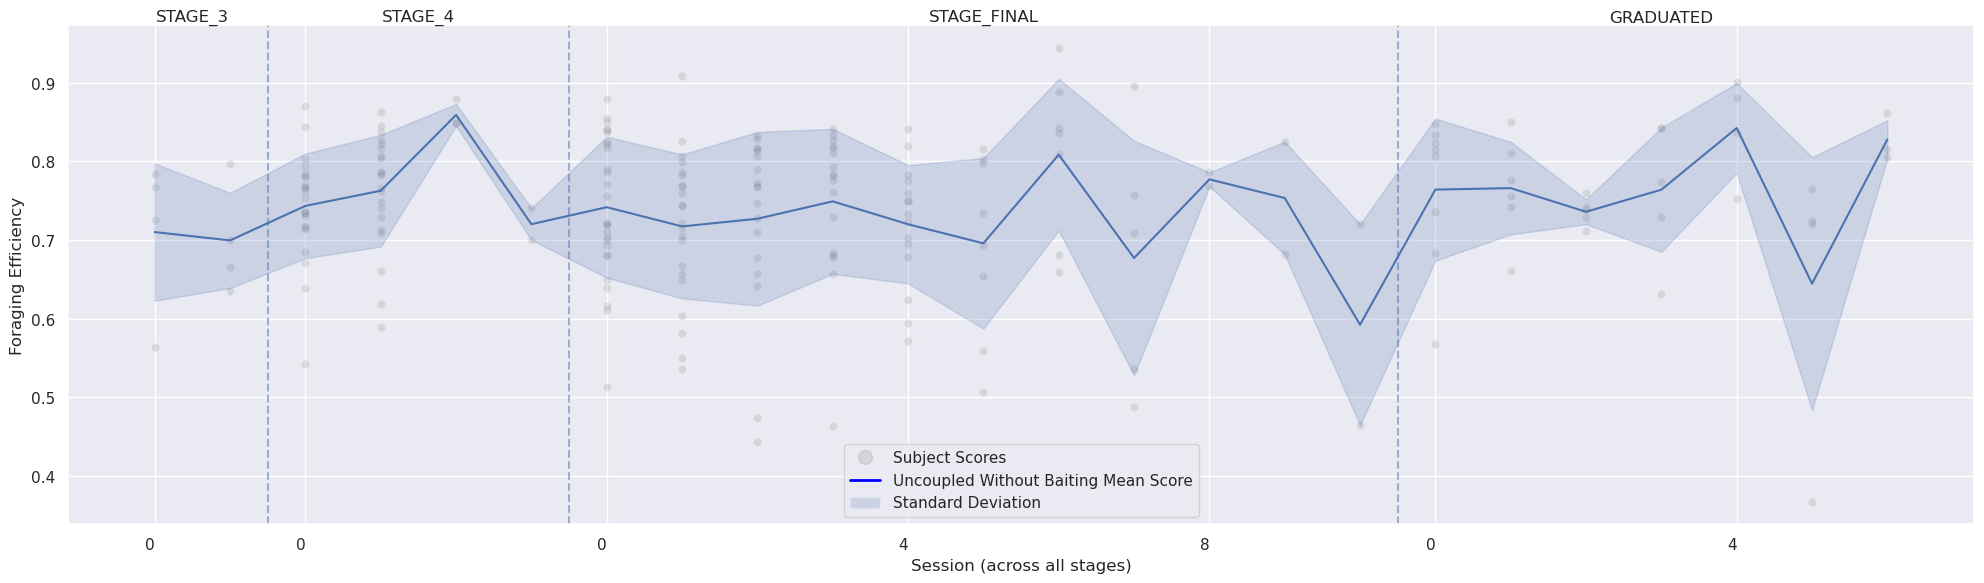


Statistics for Task: Uncoupled Without Baiting:

STAGE_3:
Number of Sessions: 2
Mean Foraging Efficiency: 0.70
Standard deviation: 0.01
Min efficiency: 0.70
Max efficiency: 0.71

STAGE_4:
Number of Sessions: 4
Mean Foraging Efficiency: 0.77
Standard deviation: 0.06
Min efficiency: 0.72
Max efficiency: 0.86

STAGE_FINAL:
Number of Sessions: 11
Mean Foraging Efficiency: 0.72
Standard deviation: 0.06
Min efficiency: 0.59
Max efficiency: 0.81

GRADUATED:
Number of Sessions: 7
Mean Foraging Efficiency: 0.76
Standard deviation: 0.07
Min efficiency: 0.64
Max efficiency: 0.84


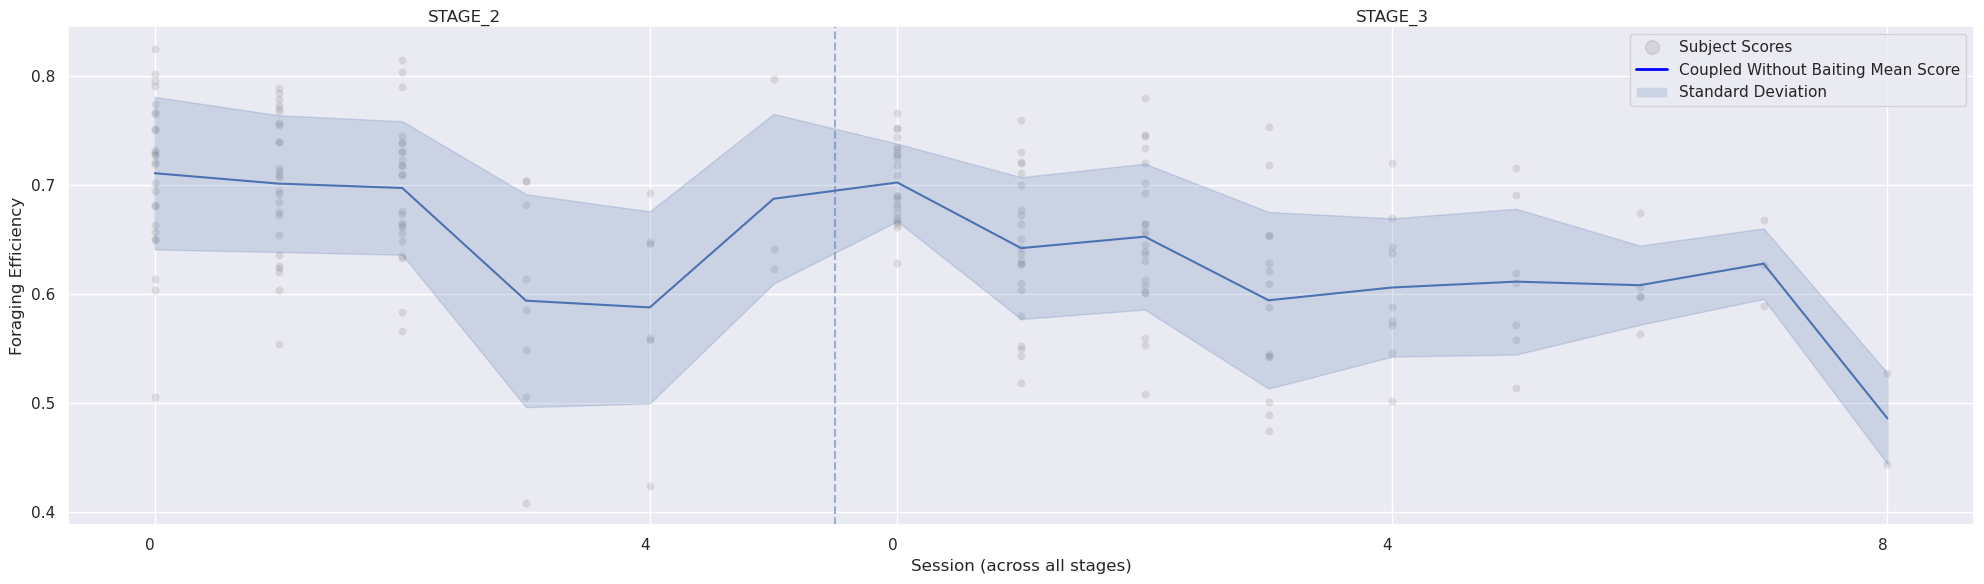


Statistics for Task: Coupled Without Baiting:

STAGE_2:
Number of Sessions: 6
Mean Foraging Efficiency: 0.66
Standard deviation: 0.06
Min efficiency: 0.59
Max efficiency: 0.71

STAGE_3:
Number of Sessions: 9
Mean Foraging Efficiency: 0.61
Standard deviation: 0.06
Min efficiency: 0.49
Max efficiency: 0.70


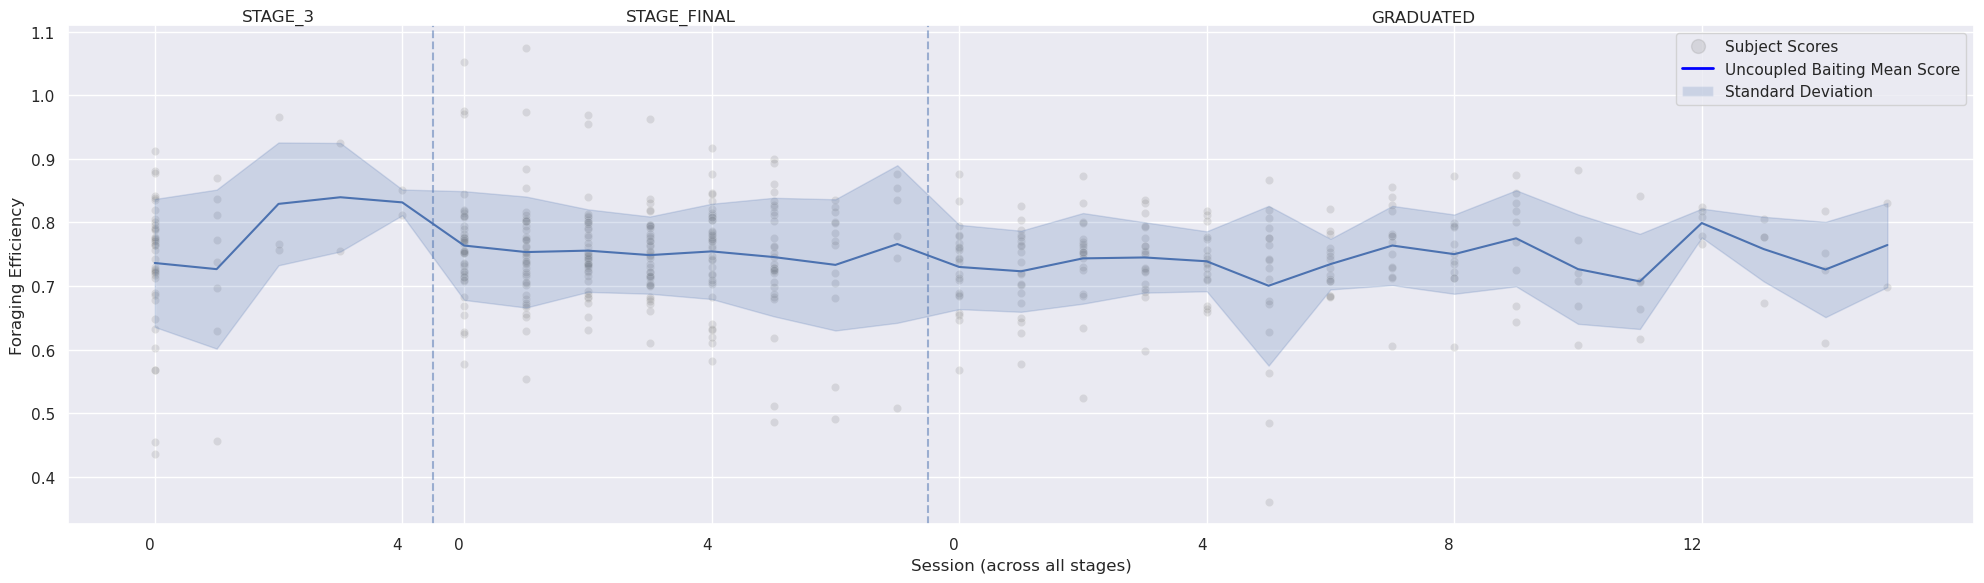


Statistics for Task: Uncoupled Baiting:

STAGE_3:
Number of Sessions: 5
Mean Foraging Efficiency: 0.79
Standard deviation: 0.06
Min efficiency: 0.73
Max efficiency: 0.84

STAGE_FINAL:
Number of Sessions: 8
Mean Foraging Efficiency: 0.75
Standard deviation: 0.01
Min efficiency: 0.73
Max efficiency: 0.77

GRADUATED:
Number of Sessions: 16
Mean Foraging Efficiency: 0.74
Standard deviation: 0.03
Min efficiency: 0.70
Max efficiency: 0.80


In [70]:

# Plot fast learners stage and task
plot_foraging_efficiency(fast_filtered_task_arrays, stage_sequence)

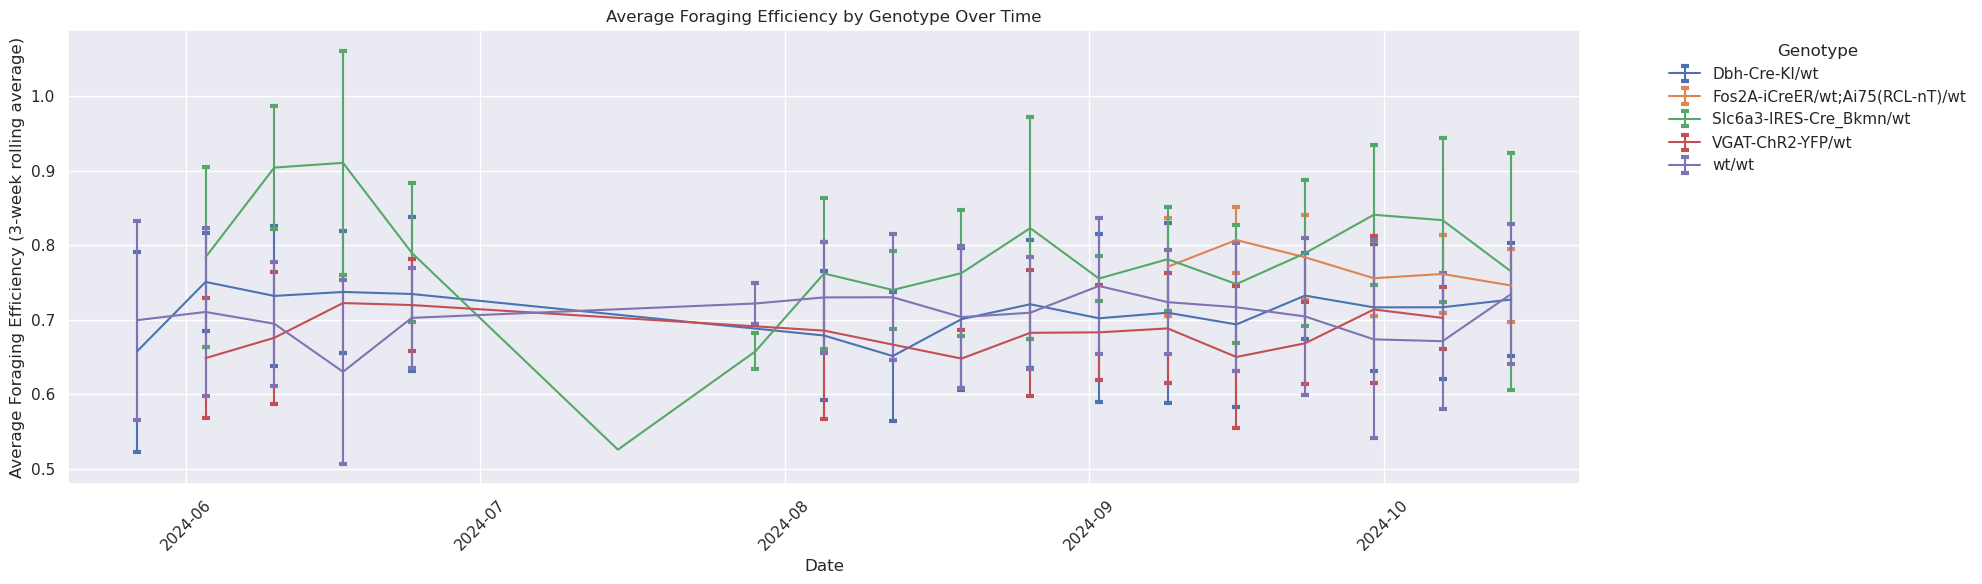

In [71]:
# Genotype plots

# Group by genotype and week
main_df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')
main_df['week'] = main_df['session_date'].dt.to_period('W')
grouped_df = main_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = main_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

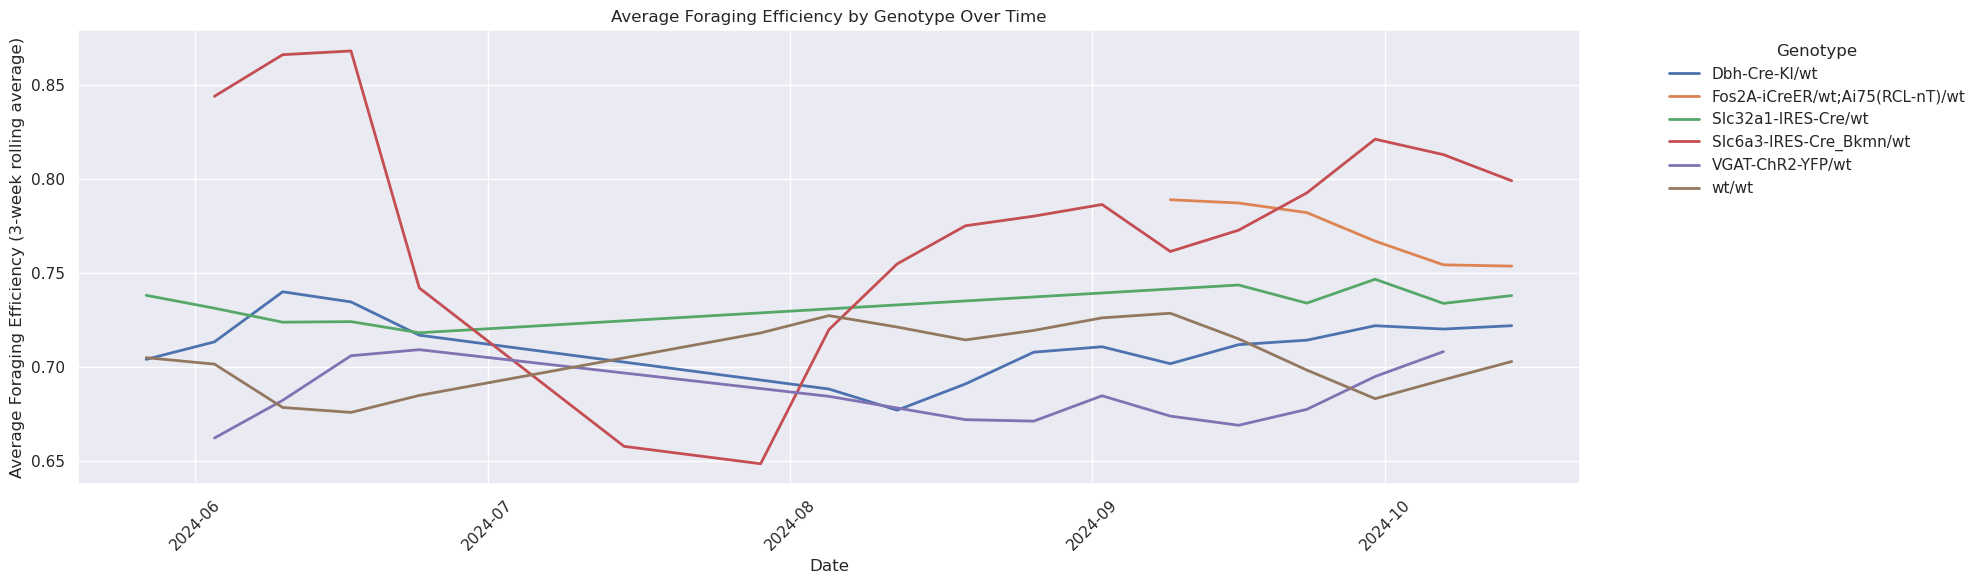

In [72]:
# Rolling average plot 

grouped_df = main_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3 week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = main_df['subject_genotype'].value_counts().nlargest(6).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2, errorbar='sd')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()